
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_2166120/4094954246.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


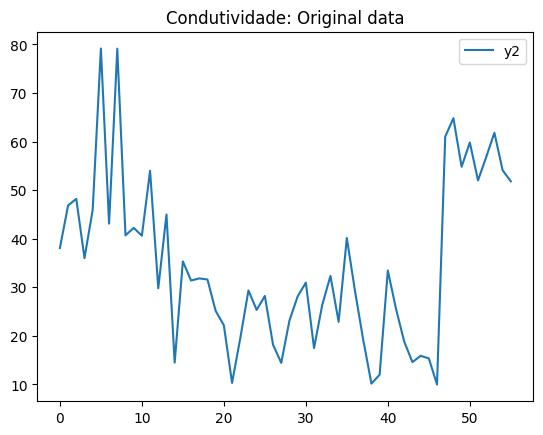

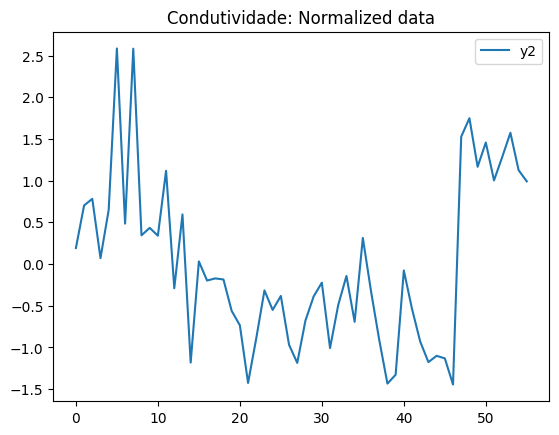

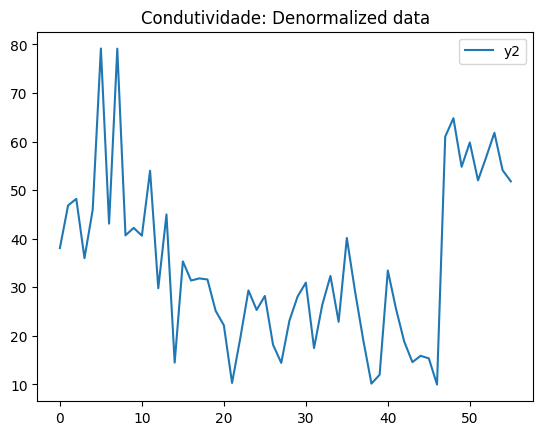

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def getData(output, label):
    df_orig = pd.read_excel("../../../data.xlsx")
    df_orig.plot(y=[output], title=f"{label}: Original data")
    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df.plot(y=[output], title=f"{label}: Normalized data")

    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    df_denorm.plot(y=[output], title=f"{label}: Denormalized data")

    return (df_orig, df)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

df_orig, df = getData(output="y2", label="Condutividade")
output, input = create_dataframe(df, output="y2")

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        
       
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-02 00:31:39.752869: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 00:31:39.786891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 00:31:39.786926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 00:31:39.788011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 00:31:39.794163: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 00:31:39.795143: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
 
 
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
   
    # Calculando as metricas com a saida desnormalizada
      pred_denorm = scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = scaler.inverse_transform(vt_pred.reshape(-1, 1))

      out_denorm = scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(out_denorm, pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(out_denorm, pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics


In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._train, trainer._vt, trainer._val, trainer._test), f)


  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)
             
    
    
  

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinacao1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.659532699999545
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.2622307700003148
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.20360938199883094
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.20712034100142773
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.3695042680010374
Stopped at epoch:  11
1/1 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.2505288440006552
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 7 +++++++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.800395,0.581708,0.518920,0.605074,0.199605,0.428393,0.292825,0.364596
model_3_5_8,0.803596,0.667483,-0.433945,0.359807,0.196404,0.340547,0.872815,0.591026
model_3_5_7,0.808718,0.677682,-0.348894,0.392186,0.191282,0.330102,0.821046,0.561134
model_3_5_1,0.810933,0.615192,0.386144,0.583543,0.189067,0.394100,0.373642,0.384473
model_3_5_6,0.813608,0.683938,-0.248697,0.426948,0.186392,0.323694,0.760058,0.529042
model_3_5_2,0.817376,0.643604,0.251757,0.558534,0.182624,0.365002,0.455441,0.407562
model_3_5_5,0.817654,0.684777,-0.135349,0.462608,0.182346,0.322836,0.691065,0.496120
model_3_5_4,0.820118,0.678827,-0.011953,0.497400,0.179882,0.328929,0.615957,0.464001
model_3_5_3,0.820250,0.665141,0.118136,0.529724,0.179750,0.342946,0.536774,0.434159


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.16146100599871716
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.15151621900076861
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.1449581160013622
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.14842418099942734
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.15672927600098774
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.16458758000226226
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.2389382

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.821920,0.229915,0.908186,0.690918,0.178080,0.307019,0.073695,0.197220
model_3_6_1,0.841396,0.208008,0.892130,0.674167,0.158604,0.315753,0.086582,0.207908
model_3_6_2,0.855555,0.175365,0.873849,0.652548,0.144445,0.328767,0.101255,0.221703
model_3_6_23,0.855942,-0.488069,0.583075,0.260966,0.144058,0.593267,0.334647,0.471563
model_3_6_22,0.857153,-0.476615,0.589086,0.268313,0.142847,0.588700,0.329822,0.466875
model_3_6_21,0.858461,-0.463864,0.595663,0.276425,0.141539,0.583616,0.324543,0.461699
model_3_6_20,0.859871,-0.449671,0.602849,0.285374,0.140129,0.577958,0.318775,0.455989
model_3_6_19,0.861381,-0.433883,0.610686,0.295235,0.138619,0.571664,0.312484,0.449697
model_3_6_18,0.862990,-0.416331,0.619218,0.306092,0.137010,0.564666,0.305636,0.442769
model_3_6_17,0.864691,-0.396836,0.628486,0.318026,0.135309,0.556894,0.298197,0.435154


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.1991021579997323
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.1448508840003342
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.14565372599827242
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.18797368200102937
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.1449170670020976
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.14556772300056764
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.174530606

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.880204,0.861305,0.986618,0.906602,0.119796,0.141987,0.008534,0.079185
model_3_7_1,0.897483,0.859655,0.976780,0.902065,0.102517,0.143676,0.014807,0.083032
model_3_7_2,0.909856,0.850200,0.965370,0.891983,0.090144,0.153355,0.022083,0.091580
model_3_7_3,0.918772,0.837397,0.953925,0.879747,0.081228,0.166462,0.029381,0.101953
model_3_7_24,0.923720,0.631120,0.835320,0.705903,0.076280,0.377635,0.105014,0.249343
model_3_7_23,0.924489,0.635407,0.837541,0.709430,0.075511,0.373246,0.103598,0.246353
model_3_7_4,0.925165,0.823220,0.943140,0.866867,0.074835,0.180976,0.036258,0.112873
model_3_7_22,0.925315,0.640107,0.839983,0.713298,0.074685,0.368435,0.102040,0.243073
model_3_7_21,0.926195,0.645252,0.842664,0.717537,0.073805,0.363167,0.100331,0.239479
model_3_7_20,0.927129,0.650876,0.845603,0.722172,0.072871,0.357409,0.098456,0.235549


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.16421636100130854
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.144840146000206
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.14909020599952783
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.14754760100186104
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.15443502299967804
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.14920618700125488
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.14594819

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.931479,0.848685,0.879484,0.870663,0.068521,0.071903,0.122195,0.095570
model_3_8_1,0.936876,0.844952,0.866991,0.861325,0.063124,0.073677,0.134862,0.102470
model_3_8_24,0.938538,0.730207,0.719596,0.727083,0.061462,0.128202,0.284310,0.201664
model_3_8_23,0.938847,0.731702,0.721338,0.728717,0.061153,0.127491,0.282544,0.200457
model_3_8_22,0.939183,0.733360,0.723269,0.730528,0.060817,0.126703,0.280587,0.199119
model_3_8_21,0.939546,0.735198,0.725407,0.732534,0.060454,0.125830,0.278419,0.197637
model_3_8_20,0.939937,0.737236,0.727774,0.734757,0.060063,0.124862,0.276018,0.195994
model_3_8_2,0.940342,0.837276,0.852206,0.849165,0.059658,0.077324,0.149853,0.111455
model_3_8_19,0.940356,0.739494,0.730395,0.737218,0.059644,0.123789,0.273361,0.194176
model_3_8_18,0.940803,0.741994,0.733295,0.739941,0.059197,0.122601,0.270421,0.192163


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.19512059399858117
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.15020507000008365
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.157230934000836
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.14579949000108172
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.15288206100012758
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.1519667530010338
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.146632418

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.933187,0.831083,0.313088,0.713138,0.066813,0.181914,0.262376,0.219778
model_3_9_23,0.933536,0.832351,0.315855,0.714731,0.066464,0.180549,0.261319,0.218558
model_3_9_22,0.933917,0.833750,0.318903,0.716487,0.066083,0.179043,0.260155,0.217213
model_3_9_21,0.934333,0.835291,0.322256,0.718420,0.065667,0.177383,0.258874,0.215732
model_3_9_20,0.934786,0.836987,0.325939,0.720547,0.065214,0.175556,0.257467,0.214102
model_3_9_19,0.935278,0.838853,0.329982,0.722883,0.064722,0.173547,0.255923,0.212312
model_3_9_18,0.935811,0.840901,0.334410,0.725447,0.064189,0.171341,0.254231,0.210348
model_3_9_17,0.936386,0.843147,0.339256,0.728255,0.063614,0.168922,0.252381,0.208197
model_3_9_16,0.937003,0.845606,0.344544,0.731325,0.062997,0.166275,0.250361,0.205845
model_3_9_15,0.937663,0.848291,0.350301,0.734674,0.062337,0.163383,0.248162,0.203279


DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.48410114199941745
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.2297150039994449
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.2817502459984098
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.2878706159972353
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.1917533560008451
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.3229453599997214
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_15,0.803746,0.342515,0.500296,0.490528,0.196254,0.837787,0.387222,0.625757
model_4_5_14,0.810104,0.366445,0.526750,0.511525,0.189896,0.807295,0.366723,0.599967
model_4_5_0,0.810885,0.819675,0.900884,0.871533,0.189115,0.229775,0.076805,0.157789
model_4_5_13,0.816726,0.392416,0.554912,0.534151,0.183274,0.774202,0.344899,0.572177
model_4_5_12,0.823523,0.420465,0.584639,0.558382,0.176477,0.738460,0.321864,0.542415
model_4_5_1,0.830326,0.793519,0.888929,0.853618,0.169674,0.263104,0.086069,0.179793
model_4_5_11,0.830367,0.450568,0.615677,0.584130,0.169633,0.700103,0.297813,0.510790
model_4_5_10,0.837082,0.482634,0.647693,0.611248,0.162918,0.659243,0.273003,0.477483
model_4_5_9,0.843436,0.516485,0.680243,0.639504,0.156564,0.616109,0.247781,0.442778
model_4_5_2,0.843782,0.764245,0.872972,0.832802,0.156218,0.300406,0.098434,0.205360


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.3592803620013001
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.2641370620003727
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.23995220600045286
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.23658081800022046
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.19856481600072584
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.22030478099986794
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.16408856

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_8,0.816643,-0.158645,0.529730,0.241138,0.183357,0.634603,0.392856,0.520840
model_4_6_7,0.839109,0.066752,0.600131,0.376687,0.160891,0.511151,0.334044,0.427806
model_4_6_0,0.852324,0.947670,0.922784,0.933664,0.147676,0.028662,0.064505,0.045529
model_4_6_6,0.859527,0.290106,0.666742,0.509202,0.140473,0.388817,0.278399,0.336856
model_4_6_1,0.868958,0.937762,0.874553,0.901853,0.131042,0.034088,0.104796,0.067363
model_4_6_5,0.875280,0.496439,0.722473,0.628295,0.124720,0.275806,0.231842,0.255117
model_4_6_2,0.878349,0.885126,0.824493,0.850942,0.121651,0.062918,0.146616,0.102305
model_4_6_4,0.883646,0.667812,0.762501,0.723624,0.116354,0.181943,0.198403,0.189689
model_4_6_3,0.883724,0.794910,0.790287,0.793235,0.116276,0.112330,0.175191,0.141912


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.21557205600038287
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.2207806400001573
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.28917062700202223
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.21857656900101574
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.20269491799990647
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.31239293300313875
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.3531880

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_15,0.802093,0.355493,-0.252711,0.263677,0.197907,0.870774,0.375924,0.637903
model_4_9_0,0.804895,0.701254,0.503658,0.672440,0.195105,0.403626,0.148946,0.283777
model_4_9_14,0.806753,0.371972,-0.204056,0.285214,0.193247,0.848509,0.361323,0.619245
model_4_9_13,0.811621,0.389739,-0.151542,0.308443,0.188379,0.824505,0.345564,0.599121
model_4_9_12,0.816612,0.408715,-0.095381,0.333265,0.183388,0.798866,0.328711,0.577617
model_4_9_1,0.817153,0.664358,0.462016,0.635190,0.182847,0.453475,0.161443,0.316048
model_4_9_11,0.821599,0.428749,-0.036115,0.359466,0.178401,0.771799,0.310926,0.554918
model_4_9_10,0.826398,0.449599,0.025215,0.386677,0.173602,0.743630,0.292522,0.531344
model_4_9_2,0.826469,0.633968,0.425435,0.604135,0.173531,0.494535,0.172420,0.342952
model_4_9_9,0.830771,0.470988,0.087034,0.414414,0.169229,0.714732,0.273970,0.507315


DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.6956900180011871
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.4719106410011591
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.20582883300085086
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.18477655999959097
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.22781386000133352
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.32317058800254017
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_5,0.801263,0.390568,0.685192,0.587866,0.198737,0.541000,0.620922,0.578610
model_5_4_4,0.803932,0.419481,0.699265,0.606848,0.196068,0.515334,0.593164,0.551960
model_5_4_0,0.804129,0.566296,0.760206,0.696284,0.195871,0.385005,0.472965,0.426398
model_5_4_3,0.805943,0.451289,0.714073,0.627286,0.194057,0.487098,0.563957,0.523267
model_5_4_1,0.806580,0.524615,0.744971,0.672260,0.193420,0.422005,0.503014,0.460127
model_5_4_2,0.806975,0.486269,0.729419,0.649141,0.193025,0.456045,0.533689,0.492584


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.21542771700114827
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.2337875470002473
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.1946918769972399
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.31403081900134566
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.29087885699846083
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.21877425499769743
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.23676382

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.815973,0.696740,0.949985,0.796993,0.184027,0.449044,0.052745,0.262550
model_5_5_1,0.834404,0.708439,0.922753,0.793634,0.165596,0.431721,0.081463,0.266894
model_5_5_23,0.844039,0.755208,0.356959,0.604872,0.155961,0.362469,0.678143,0.511021
model_5_5_22,0.845409,0.755026,0.367631,0.608857,0.154591,0.362738,0.666888,0.505868
model_5_5_21,0.846891,0.754806,0.379407,0.613242,0.153109,0.363064,0.654469,0.500196
model_5_5_2,0.847755,0.717147,0.891270,0.786831,0.152245,0.418827,0.114665,0.275692
model_5_5_20,0.848487,0.754540,0.392386,0.618062,0.151513,0.363457,0.640782,0.493963
model_5_5_19,0.850197,0.754220,0.406674,0.623350,0.149803,0.363931,0.625715,0.487123
model_5_5_18,0.852020,0.753834,0.422378,0.629142,0.147980,0.364503,0.609154,0.479633
model_5_5_17,0.853949,0.753371,0.439605,0.635472,0.146051,0.365188,0.590985,0.471446


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.2098809919989435
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.20532602300227154
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.2261298289995466
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.20810825800072053
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.23999349099904066
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.21961527300300077
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.25304158

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.871522,0.920033,0.934351,0.931577,0.128478,0.028401,0.053397,0.040164
model_5_6_1,0.893296,0.902149,0.940115,0.929607,0.106704,0.034753,0.048709,0.041320
model_5_6_2,0.910521,0.880207,0.944845,0.925663,0.089479,0.042546,0.044862,0.043636
model_5_6_3,0.924110,0.856244,0.948581,0.920423,0.075890,0.051057,0.041823,0.046711
model_5_6_4,0.934790,0.831620,0.951374,0.914357,0.065210,0.059802,0.039551,0.050272
model_5_6_5,0.943139,0.807218,0.953286,0.907787,0.056861,0.068469,0.037996,0.054129
model_5_6_6,0.949624,0.783588,0.954391,0.900938,0.050376,0.076861,0.037097,0.058149
model_5_6_7,0.954618,0.761060,0.954778,0.893974,0.045382,0.084863,0.036783,0.062237
model_5_6_8,0.958424,0.739810,0.954546,0.887016,0.041576,0.092410,0.036971,0.066321
model_5_6_9,0.961285,0.719917,0.953800,0.880157,0.038715,0.099475,0.037578,0.070347


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.1972516710011405
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.14707406600064132
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.153758996999386
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.15555986300023505
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.190659293999488
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.1498264419969928
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.165987789001

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.971429,0.986003,0.995651,0.989445,0.028571,0.012361,0.002395,0.007671
model_5_7_1,0.975777,0.983785,0.991741,0.986624,0.024223,0.014320,0.004548,0.009721
model_5_7_2,0.978998,0.981125,0.986259,0.982957,0.021002,0.016669,0.007567,0.012386
model_5_7_24,0.981161,0.938616,0.873419,0.915371,0.018839,0.054210,0.069710,0.061504
model_5_7_3,0.981338,0.978213,0.979718,0.978751,0.018662,0.019241,0.011170,0.015443
model_5_7_23,0.981387,0.939344,0.875479,0.916575,0.018613,0.053567,0.068576,0.060630
model_5_7_22,0.981631,0.940148,0.877750,0.917901,0.018369,0.052858,0.067325,0.059666
model_5_7_21,0.981893,0.941033,0.880250,0.919362,0.018107,0.052076,0.065948,0.058604
model_5_7_20,0.982174,0.942007,0.883000,0.920969,0.017826,0.051216,0.064434,0.057436
model_5_7_19,0.982472,0.943078,0.886020,0.922735,0.017528,0.050270,0.062771,0.056153


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.15575701099805883
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.14809637500002282
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.1443731420004042
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.15196882999953232
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.14741715399941313
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.15787798000019393
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.1486543

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.974158,0.907829,0.941135,0.923364,0.025842,0.104288,0.063195,0.084950
model_5_8_23,0.974424,0.908724,0.941888,0.924192,0.025576,0.103275,0.062386,0.084033
model_5_8_22,0.974715,0.909713,0.942717,0.925103,0.025285,0.102156,0.061497,0.083023
model_5_8_21,0.975034,0.910803,0.943626,0.926107,0.024966,0.100923,0.060521,0.081910
model_5_8_20,0.975382,0.912003,0.944624,0.927210,0.024618,0.099565,0.059450,0.080687
model_5_8_19,0.975761,0.913324,0.945717,0.928422,0.024239,0.098070,0.058277,0.079344
model_5_8_18,0.976172,0.914776,0.946911,0.929751,0.023828,0.096427,0.056994,0.077871
model_5_8_17,0.976617,0.916370,0.948213,0.931206,0.023383,0.094624,0.055596,0.076258
model_5_8_16,0.977098,0.918116,0.949630,0.932795,0.022902,0.092648,0.054075,0.074496
model_5_8_15,0.977613,0.920027,0.951167,0.934528,0.022387,0.090486,0.052425,0.072575


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.15011064099962823
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.14428810400204384
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.14346445800038055
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.16400244100077543
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.1460001099985675
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.16135687199857784
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.1450912

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.978563,0.995056,0.939188,0.984372,0.021437,0.004618,0.017157,0.010519
model_5_9_1,0.981996,0.994490,0.940471,0.984209,0.018004,0.005148,0.016795,0.010629
model_5_9_2,0.984650,0.993781,0.939329,0.983463,0.015350,0.005810,0.017117,0.011131
model_5_9_3,0.986685,0.992969,0.936420,0.982293,0.013315,0.006568,0.017938,0.011919
model_5_9_4,0.988227,0.992086,0.932269,0.980826,0.011773,0.007393,0.019109,0.012906
model_5_9_5,0.989379,0.991160,0.927288,0.979162,0.010621,0.008258,0.020514,0.014026
model_5_9_6,0.990225,0.990214,0.921795,0.977383,0.009775,0.009142,0.022064,0.015223
model_5_9_24,0.990591,0.978760,0.848548,0.954520,0.009409,0.019843,0.042729,0.030613
model_5_9_23,0.990688,0.979067,0.850503,0.955131,0.009312,0.019556,0.042177,0.030201
model_5_9_22,0.990792,0.979404,0.852652,0.955802,0.009208,0.019241,0.041571,0.029749


DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.33842145100061316
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.19189050199929625
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.25800888999947347
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.19264619299792685
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.19204509799965308
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.14394727400213014
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_0,0.811780,0.688045,0.735288,0.750206,0.188220,0.203105,0.229862,0.215697
model_6_4_1,0.828691,0.649155,0.721056,0.727947,0.171309,0.228425,0.242221,0.234917
model_6_4_20,0.835897,0.240748,0.331816,0.380721,0.164103,0.494326,0.580217,0.534746
model_6_4_19,0.838351,0.252214,0.345282,0.391670,0.161649,0.486861,0.568524,0.525291
model_6_4_18,0.840969,0.264752,0.359970,0.403626,0.159031,0.478698,0.555770,0.514967
model_6_4_2,0.841716,0.612751,0.707715,0.707102,0.158284,0.252127,0.253806,0.252917
model_6_4_17,0.843746,0.278431,0.375950,0.416648,0.156254,0.469792,0.541894,0.503722
model_6_4_16,0.846665,0.293317,0.393280,0.430792,0.153335,0.460100,0.526845,0.491509
model_6_4_15,0.849703,0.309470,0.412010,0.446103,0.150297,0.449584,0.510581,0.478288
model_6_4_3,0.851725,0.579646,0.694571,0.687667,0.148275,0.273680,0.265219,0.269699


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.16018965900002513
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.14823883999997634
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.14494058299897006
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.15277424899977632
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.1456504669986316
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.14619468099772348
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.1884059

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.852890,0.661060,0.972293,0.776708,0.147110,0.439890,0.022829,0.243626
model_6_5_1,0.866039,0.659795,0.968763,0.774656,0.133961,0.441532,0.025738,0.245864
model_6_5_2,0.876153,0.658561,0.961969,0.771466,0.123847,0.443133,0.031335,0.249346
model_6_5_3,0.883842,0.657268,0.952699,0.767356,0.116158,0.444812,0.038973,0.253829
model_6_5_24,0.887721,0.629500,0.706673,0.662438,0.112279,0.480850,0.241685,0.368302
model_6_5_23,0.888433,0.630177,0.712473,0.664925,0.111567,0.479971,0.236906,0.365588
model_6_5_22,0.889201,0.630918,0.718843,0.667656,0.110799,0.479009,0.231658,0.362609
model_6_5_4,0.889572,0.655870,0.941426,0.762470,0.110428,0.446626,0.048262,0.259160
model_6_5_21,0.890022,0.631727,0.725826,0.670647,0.109978,0.477959,0.225904,0.359345
model_6_5_20,0.890897,0.632609,0.733468,0.673919,0.109103,0.476814,0.219607,0.355776


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.19670128999860026
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.145244878000085
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.14521465999860084
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.16953336900041904
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.1542683420011599
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.14631398400160833
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.157253050

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_0,0.904328,0.686785,-1.398123,0.663250,0.095672,0.315771,0.211116,0.266521
model_6_6_1,0.907431,0.685768,-1.362044,0.664453,0.092569,0.316795,0.207940,0.265570
model_6_6_2,0.909738,0.684380,-1.341762,0.664579,0.090262,0.318195,0.206155,0.265470
model_6_6_3,0.911427,0.682775,-1.333357,0.663937,0.088573,0.319813,0.205415,0.265978
model_6_6_24,0.912413,0.660419,-1.582122,0.635839,0.087587,0.342351,0.227315,0.288216
model_6_6_23,0.912540,0.660812,-1.575331,0.636459,0.087460,0.341955,0.226717,0.287725
model_6_6_4,0.912636,0.681062,-1.333701,0.662763,0.087364,0.321540,0.205445,0.266907
model_6_6_22,0.912677,0.661246,-1.567887,0.637141,0.087323,0.341518,0.226062,0.287185
model_6_6_21,0.912824,0.661725,-1.559729,0.637892,0.087176,0.341034,0.225343,0.286592
model_6_6_20,0.912980,0.662255,-1.550816,0.638715,0.087020,0.340501,0.224559,0.285940


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.17229526599840028
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.17298348899930716
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.14335897999990266
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.156849435003096
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.1607484169981035
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.15259606999825337
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.147323055

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_24,0.855078,0.868864,-0.170005,0.461082,0.144922,0.132893,0.863013,0.476479
model_6_7_23,0.856721,0.870091,-0.155687,0.467448,0.143279,0.131649,0.852451,0.470850
model_6_7_22,0.858529,0.871459,-0.139888,0.474481,0.141471,0.130262,0.840798,0.464632
model_6_7_21,0.860513,0.872985,-0.122474,0.482243,0.139487,0.128716,0.827954,0.457769
model_6_7_20,0.862689,0.874688,-0.103295,0.490807,0.137311,0.126990,0.813806,0.450198
model_6_7_19,0.865071,0.876588,-0.082191,0.500245,0.134929,0.125065,0.798240,0.441853
model_6_7_18,0.867674,0.878710,-0.058996,0.510639,0.132326,0.122915,0.781131,0.432663
model_6_7_17,0.870513,0.881079,-0.033531,0.522074,0.129487,0.120513,0.762348,0.422553
model_6_7_16,0.873601,0.883727,-0.005616,0.534640,0.126399,0.117831,0.741757,0.411443
model_6_7_15,0.876951,0.886685,0.024939,0.548431,0.123049,0.114832,0.719220,0.399250


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.15893556800074293
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.14632955500201206
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.161007980001159
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.1888628089982376
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.2853935820021434
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.16732877899994492
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.2143204019

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.856175,0.940764,-0.301786,0.598447,0.143825,0.095412,0.897909,0.473057
model_6_8_23,0.856644,0.941577,-0.298637,0.599903,0.143356,0.094103,0.895737,0.471343
model_6_8_22,0.857157,0.942466,-0.295132,0.601512,0.142843,0.092670,0.893319,0.469446
model_6_8_21,0.857714,0.943438,-0.291231,0.603290,0.142286,0.091105,0.890629,0.467351
model_6_8_20,0.858320,0.944497,-0.286887,0.605254,0.141680,0.089399,0.887632,0.465038
model_6_8_19,0.858976,0.945649,-0.282050,0.607420,0.141024,0.087543,0.884296,0.462486
model_6_8_18,0.859683,0.946898,-0.276661,0.609809,0.140317,0.085531,0.880579,0.459671
model_6_8_17,0.860443,0.948249,-0.270660,0.612440,0.139557,0.083356,0.876440,0.456572
model_6_8_0,0.860874,0.974454,0.003689,0.706999,0.139126,0.041147,0.687208,0.345175
model_6_8_16,0.861255,0.949702,-0.263970,0.615336,0.138745,0.081015,0.871826,0.453161


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.1694174619988189
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.14364010899953428
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.1444012960018881
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.15147114399951533
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.1458301519996894
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.16216054500182508
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.145395175

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_24,0.807617,0.639163,-0.377733,0.281106,0.192383,0.388172,0.906551,0.632115
model_6_9_23,0.809575,0.645856,-0.367988,0.288874,0.190425,0.380971,0.900138,0.625285
model_6_9_22,0.811705,0.653159,-0.357256,0.297383,0.188295,0.373115,0.893077,0.617803
model_6_9_21,0.814015,0.661111,-0.345446,0.306692,0.185985,0.364561,0.885306,0.609617
model_6_9_20,0.816513,0.669749,-0.332462,0.316860,0.183487,0.355269,0.876762,0.600677
model_6_9_19,0.819206,0.679111,-0.318196,0.327947,0.180794,0.345198,0.867375,0.590928
model_6_9_18,0.822099,0.689227,-0.302535,0.340014,0.177901,0.334315,0.857070,0.580317
model_6_9_17,0.825193,0.700128,-0.285359,0.353124,0.174807,0.322589,0.845768,0.568791
model_6_9_16,0.828486,0.711833,-0.266533,0.367335,0.171514,0.309996,0.833381,0.556295
model_6_9_15,0.831974,0.724359,-0.245917,0.382708,0.168026,0.296522,0.819815,0.542777


DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.351147838999168
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.18553398999938508
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.14628941800037865
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.14464577700346126
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.14713502199811046
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.14466416100185597
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_1_0,0.808249,0.194962,0.690499,0.546272,0.191751,0.342602,0.233714,0.291361
model_7_1_14,0.811860,-0.237744,0.090415,0.062377,0.188140,0.526750,0.686856,0.602094
model_7_1_13,0.814012,-0.220733,0.111249,0.079875,0.185988,0.519511,0.671124,0.590858
model_7_1_12,0.816232,-0.202127,0.134442,0.099238,0.183768,0.511593,0.653610,0.578424
model_7_1_1,0.817592,0.148593,0.623609,0.492988,0.182408,0.362336,0.284224,0.325578
model_7_1_11,0.818487,-0.181792,0.160261,0.120660,0.181513,0.502939,0.634113,0.564668
model_7_1_10,0.820732,-0.159593,0.188989,0.144346,0.179268,0.493491,0.612420,0.549458
model_7_1_9,0.822904,-0.135374,0.220935,0.170522,0.177096,0.483185,0.588296,0.532649
model_7_1_2,0.823463,0.103824,0.558534,0.441269,0.176537,0.381388,0.333364,0.358789
model_7_1_8,0.824917,-0.108978,0.256419,0.199420,0.175083,0.471951,0.561501,0.514092


DataFrame salvo em ../results/metrics_7_1
+++++++++++ [7_2] | 1 ++++++++++++++++++
Elapsed time:  0.15140797200001543
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_2] | 2 ++++++++++++++++++
Elapsed time:  0.1930132869965746
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_2] | 3 ++++++++++++++++++
Elapsed time:  0.1495129389986687
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_2] | 4 ++++++++++++++++++
Elapsed time:  0.14686860800065915
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_2] | 5 ++++++++++++++++++
Elapsed time:  0.14962835599726532
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_2] | 6 ++++++++++++++++++
Elapsed time:  0.19288934400174185
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_2] | 7 ++++++++++++++++++
Elapsed time:  0.16164186

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_14,0.800546,-0.392498,0.463104,0.252481,0.199454,0.588451,0.685891,0.634305
model_7_2_13,0.809036,-0.318557,0.490960,0.291711,0.190964,0.557205,0.650305,0.601016
model_7_2_12,0.817811,-0.239177,0.520435,0.333523,0.182189,0.523660,0.612650,0.565537
model_7_2_11,0.826745,-0.154504,0.551379,0.377770,0.173255,0.487878,0.573119,0.527991
model_7_2_10,0.835663,-0.064861,0.583567,0.424210,0.164337,0.449996,0.531998,0.488585
model_7_2_0,0.839658,0.945720,0.875897,0.897764,0.160342,0.022938,0.158543,0.086752
model_7_2_9,0.844338,0.029276,0.616696,0.472500,0.155662,0.410215,0.489675,0.447608
model_7_2_8,0.852497,0.127417,0.650392,0.522249,0.147503,0.368742,0.446629,0.405394
model_7_2_1,0.857229,0.869891,0.859091,0.865865,0.142771,0.054982,0.180013,0.113820
model_7_2_7,0.859823,0.229178,0.684226,0.573050,0.140177,0.325739,0.403404,0.362287


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.15549350799847161
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.15376899700277136
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.14710672199726105
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.14933012799883727
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.1481229870005336
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.189842375999433
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.145795797

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_0,0.821152,0.804841,0.938462,0.881564,0.178848,0.131650,0.059451,0.097674
model_7_3_1,0.846517,0.812480,0.907815,0.867978,0.153483,0.126497,0.089058,0.108879
model_7_3_2,0.864515,0.814077,0.868517,0.847007,0.135485,0.125420,0.127022,0.126174
model_7_3_23,0.871946,0.658302,0.348805,0.493054,0.128054,0.230503,0.629103,0.418079
model_7_3_22,0.873258,0.662671,0.356813,0.499361,0.126742,0.227555,0.621366,0.412878
model_7_3_21,0.874674,0.667446,0.365706,0.506331,0.125326,0.224334,0.612775,0.407130
model_7_3_20,0.876194,0.672656,0.375578,0.514029,0.123806,0.220819,0.603238,0.400781
model_7_3_3,0.876973,0.811371,0.825068,0.821883,0.123027,0.127245,0.168997,0.146893
model_7_3_19,0.877818,0.678324,0.386538,0.522525,0.122182,0.216996,0.592650,0.393774
model_7_3_18,0.879543,0.684473,0.398703,0.531894,0.120457,0.212848,0.580898,0.386048


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.38446854400172015
Stopped at epoch:  17
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.19823732599979849
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.24597069499941426
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.15101390500058187
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.14697045600041747
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.14576352500080247
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.14307

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_24,0.936105,0.574553,0.879901,0.784675,0.063895,0.263057,0.151036,0.210342
model_7_4_23,0.936243,0.575861,0.879999,0.785172,0.063757,0.262249,0.150914,0.209856
model_7_4_22,0.936395,0.577310,0.880106,0.785723,0.063605,0.261352,0.150779,0.209318
model_7_4_21,0.936561,0.578917,0.880224,0.786333,0.063439,0.260359,0.150630,0.208722
model_7_4_20,0.936743,0.580698,0.880354,0.787008,0.063257,0.259257,0.150468,0.208062
model_7_4_19,0.936943,0.582672,0.880496,0.787756,0.063057,0.258037,0.150288,0.207332
model_7_4_18,0.937160,0.584857,0.880652,0.788582,0.062840,0.256686,0.150093,0.206525
model_7_4_17,0.937397,0.587274,0.880822,0.789495,0.062603,0.255191,0.149878,0.205632
model_7_4_16,0.937655,0.589951,0.881008,0.790505,0.062345,0.253536,0.149645,0.204646
model_7_4_15,0.937933,0.592911,0.881210,0.791619,0.062067,0.251707,0.149391,0.203558


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.15514368000003742
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.19896154500020202
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.14287277000039467
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.14532329900248442
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.1467834020004375
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.14464858700011973
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.2563541

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_24,0.914131,0.776427,0.579879,0.740324,0.085869,0.340235,0.216109,0.281822
model_7_5_23,0.915326,0.780019,0.585195,0.744176,0.084674,0.334769,0.213374,0.277642
model_7_5_22,0.916640,0.783994,0.591087,0.748440,0.083360,0.328720,0.210343,0.273014
model_7_5_21,0.918081,0.788389,0.597612,0.753159,0.081919,0.322031,0.206987,0.267893
model_7_5_20,0.919661,0.793246,0.604835,0.758376,0.080339,0.314639,0.203271,0.262231
model_7_5_19,0.921388,0.798609,0.612825,0.764139,0.078612,0.306479,0.199161,0.255976
model_7_5_18,0.923271,0.804521,0.621657,0.770497,0.076729,0.297482,0.194618,0.249076
model_7_5_17,0.925318,0.811030,0.631410,0.777505,0.074682,0.287576,0.189601,0.241470
model_7_5_16,0.927535,0.818183,0.642166,0.785214,0.072465,0.276690,0.184069,0.233103
model_7_5_15,0.929926,0.826028,0.654011,0.793680,0.070074,0.264752,0.177975,0.223916


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.15485609100142028
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.14860976499767276
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.1504972969996743
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.14345430100001977
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.14731178299916792
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.19483797599968966
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.1434931

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.929302,0.965644,0.990287,0.974541,0.070698,0.048450,0.008695,0.029742
model_7_6_1,0.940891,0.967946,0.985442,0.974265,0.059109,0.045204,0.013032,0.030064
model_7_6_2,0.949676,0.968679,0.978851,0.972357,0.050324,0.044170,0.018932,0.032293
model_7_6_3,0.956259,0.968175,0.971266,0.969300,0.043741,0.044880,0.025722,0.035864
model_7_6_4,0.961113,0.966711,0.963208,0.965459,0.038887,0.046945,0.032935,0.040352
model_7_6_24,0.963932,0.917021,0.868125,0.899416,0.036068,0.117019,0.118051,0.117505
model_7_6_23,0.964352,0.918267,0.869926,0.900862,0.035648,0.115262,0.116438,0.115815
model_7_6_5,0.964613,0.964523,0.955035,0.961113,0.035387,0.050031,0.040251,0.045429
model_7_6_22,0.964803,0.919638,0.871917,0.902456,0.035197,0.113328,0.114656,0.113953
model_7_6_21,0.965284,0.921145,0.874114,0.904211,0.034716,0.111204,0.112689,0.111903


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.27336622599978
Stopped at epoch:  12
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.1496498239976063
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.14347203099896433
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.15949362999890582
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.1941817090009863
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.14471319899894297
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.1436474050

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_24,0.984484,0.916829,0.979832,0.937418,0.015516,0.086258,0.011330,0.050998
model_7_7_23,0.984578,0.917319,0.980082,0.937829,0.015422,0.085750,0.011189,0.050663
model_7_7_22,0.984680,0.917861,0.980353,0.938282,0.015320,0.085187,0.011037,0.050293
model_7_7_21,0.984792,0.918462,0.980645,0.938782,0.015208,0.084564,0.010873,0.049886
model_7_7_20,0.984913,0.919127,0.980959,0.939332,0.015087,0.083875,0.010697,0.049438
model_7_7_19,0.985044,0.919863,0.981294,0.939936,0.014956,0.083112,0.010509,0.048946
model_7_7_18,0.985185,0.920676,0.981649,0.940599,0.014815,0.082268,0.010309,0.048405
model_7_7_17,0.985336,0.921575,0.982023,0.941326,0.014664,0.081336,0.010099,0.047813
model_7_7_16,0.985498,0.922568,0.982412,0.942122,0.014502,0.080306,0.009880,0.047164
model_7_7_0,0.985655,0.959129,0.973077,0.963727,0.014345,0.042388,0.015125,0.029558


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.25060012199901394
Stopped at epoch:  11
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.14645482400010224
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.15060524300133693
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.1536317850004707
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.14451695399839082
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.14521915200020885
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.142904

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_24,0.990712,0.951096,0.986517,0.974302,0.009288,0.039325,0.020633,0.030529
model_7_8_23,0.990767,0.951463,0.986573,0.974467,0.009233,0.039030,0.020547,0.030332
model_7_8_22,0.990827,0.951869,0.986634,0.974650,0.009173,0.038704,0.020453,0.030115
model_7_8_21,0.990893,0.952318,0.986702,0.974852,0.009107,0.038343,0.020349,0.029875
model_7_8_20,0.990964,0.952813,0.986776,0.975075,0.009036,0.037944,0.020236,0.029611
model_7_8_19,0.991041,0.953360,0.986857,0.975320,0.008959,0.037505,0.020111,0.029319
model_7_8_18,0.991125,0.953964,0.986946,0.975590,0.008875,0.037019,0.019975,0.028998
model_7_8_17,0.991215,0.954628,0.987044,0.975887,0.008785,0.036485,0.019827,0.028646
model_7_8_16,0.991312,0.955360,0.987149,0.976214,0.008688,0.035896,0.019665,0.028258
model_7_8_15,0.991416,0.956164,0.987264,0.976571,0.008584,0.035250,0.019489,0.027833


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.2723120590017061
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.15222652599914
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.16475552799965953
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.1534734729975753
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.1491840790004062
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.14582351700300933
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.185954254000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_0,0.994308,0.998124,0.966179,0.982395,0.005692,0.000920,0.021637,0.010669
model_7_9_1,0.994774,0.997802,0.966464,0.982398,0.005226,0.001079,0.021455,0.010667
model_7_9_2,0.995132,0.997392,0.966606,0.982293,0.004868,0.001280,0.021364,0.010731
model_7_9_3,0.995404,0.996922,0.966638,0.982107,0.004596,0.001511,0.021343,0.010844
model_7_9_4,0.995607,0.996415,0.966587,0.981865,0.004393,0.001759,0.021376,0.010991
model_7_9_5,0.995756,0.995890,0.966474,0.981584,0.004244,0.002017,0.021448,0.011161
model_7_9_24,0.995785,0.989416,0.963180,0.977172,0.004215,0.005194,0.023556,0.013835
model_7_9_23,0.995802,0.989567,0.963277,0.977285,0.004198,0.005120,0.023493,0.013766
model_7_9_22,0.995820,0.989732,0.963384,0.977409,0.004180,0.005039,0.023425,0.013691
model_7_9_21,0.995839,0.989914,0.963500,0.977544,0.004161,0.004949,0.023351,0.013609


DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.3377490819984814
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.18063957300182665
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.15024927299964475
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.25671248200160335
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.20895322800060967
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.16764422499909415
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.801223,0.262985,0.926509,0.563808,0.198777,0.833539,0.073182,0.475724
model_8_4_21,0.808609,0.189023,0.695316,0.423867,0.191391,0.917186,0.303404,0.628347
model_8_4_20,0.809820,0.192584,0.700337,0.427979,0.190180,0.913160,0.298404,0.623863
model_8_4_19,0.811118,0.196471,0.705808,0.432464,0.188882,0.908763,0.292956,0.618971
model_8_4_1,0.812198,0.279669,0.909349,0.565594,0.187802,0.814670,0.090270,0.473776
model_8_4_18,0.812504,0.200705,0.711756,0.437344,0.187496,0.903975,0.287033,0.613650
model_8_4_17,0.813974,0.205306,0.718209,0.442643,0.186026,0.898771,0.280607,0.607870
model_8_4_16,0.815523,0.210294,0.725196,0.448383,0.184477,0.893131,0.273649,0.601610
model_8_4_15,0.817144,0.215685,0.732744,0.454586,0.182856,0.887033,0.266133,0.594845
model_8_4_14,0.818821,0.221493,0.740877,0.461269,0.181179,0.880465,0.258034,0.587556


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.17829243799860706
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.1401542170024186
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.14614096199875348
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.14541959499911172
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.14905987100064522
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.15604320400234428
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.1430088

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.860245,0.942497,0.451909,0.735995,0.139755,0.037739,0.330133,0.175336
model_8_5_1,0.877230,0.950269,0.449812,0.739166,0.122770,0.032638,0.331396,0.173230
model_8_5_24,0.887546,0.935450,-0.221295,0.444989,0.112454,0.042364,0.735625,0.368604
model_8_5_23,0.888702,0.936426,-0.207547,0.451367,0.111298,0.041723,0.727344,0.364368
model_8_5_2,0.889845,0.956724,0.434487,0.736002,0.110155,0.028402,0.340627,0.175331
model_8_5_22,0.889951,0.937502,-0.192480,0.458361,0.110049,0.041017,0.718269,0.359723
model_8_5_21,0.891296,0.938689,-0.175997,0.466016,0.108704,0.040238,0.708340,0.354639
model_8_5_20,0.892737,0.939995,-0.157996,0.474382,0.107263,0.039381,0.697498,0.349083
model_8_5_19,0.894275,0.941432,-0.138379,0.483507,0.105725,0.038438,0.685682,0.343023
model_8_5_18,0.895903,0.943010,-0.117045,0.493438,0.104097,0.037402,0.672832,0.336428


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.1474830099978135
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.14397412100151996
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.1410332550003659
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.1901254410004185
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.1417116150005313
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.14188897900021402
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.1501302000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_24,0.821960,0.379932,-0.477852,0.162197,0.178040,0.566646,0.606883,0.585581
model_8_6_23,0.824065,0.392424,-0.472151,0.172420,0.175935,0.555230,0.604542,0.578436
model_8_6_22,0.826371,0.406162,-0.465886,0.183662,0.173629,0.542676,0.601969,0.570579
model_8_6_21,0.828892,0.421246,-0.459003,0.196006,0.171108,0.528891,0.599143,0.561951
model_8_6_20,0.831642,0.437777,-0.451451,0.209536,0.168358,0.513785,0.596042,0.552494
model_8_6_19,0.834635,0.455859,-0.443160,0.224344,0.165365,0.497261,0.592637,0.542144
model_8_6_18,0.837881,0.475583,-0.434057,0.240514,0.162119,0.479236,0.588899,0.530842
model_8_6_17,0.841391,0.497035,-0.424053,0.258129,0.158609,0.459632,0.584790,0.518530
model_8_6_16,0.845171,0.520282,-0.413042,0.277264,0.154829,0.438388,0.580269,0.505155
model_8_6_15,0.849222,0.545369,-0.400880,0.297992,0.150778,0.415462,0.575274,0.490668


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.23412630399980117
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.23853135399986058
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.14204824799890048
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.1407485199997609
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.1427431140000408
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.1404877260029025
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.14243800

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_18,0.800918,-0.734760,0.960935,0.420735,0.199082,1.176897,0.063281,0.652843
model_8_7_17,0.804485,-0.701964,0.961810,0.431779,0.195515,1.154648,0.061864,0.640397
model_8_7_16,0.808384,-0.665805,0.962746,0.443936,0.191616,1.130117,0.060346,0.626696
model_8_7_15,0.812637,-0.625967,0.963743,0.457306,0.187363,1.103090,0.058731,0.611627
model_8_7_14,0.817267,-0.582099,0.964799,0.472000,0.182733,1.073329,0.057022,0.595067
model_8_7_13,0.822296,-0.533826,0.965907,0.488133,0.177704,1.040580,0.055226,0.576884
model_8_7_12,0.827747,-0.480723,0.967064,0.505839,0.172253,1.004554,0.053352,0.556930
model_8_7_11,0.833644,-0.422308,0.968260,0.525264,0.166356,0.964924,0.051415,0.535037
model_8_7_10,0.840010,-0.358025,0.969487,0.546580,0.159990,0.921313,0.049427,0.511014
model_8_7_9,0.846876,-0.287198,0.970737,0.569997,0.153124,0.873262,0.047402,0.484622


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.159912107999844
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.14135891499972786
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.14175675400110777
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.15118443300161744
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.14175109599818825
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.1424139870032377
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.172623947

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.818186,0.974765,0.783857,0.909388,0.181814,0.033137,0.187626,0.105838
model_8_8_1,0.843793,0.971839,0.766315,0.901512,0.156207,0.036980,0.202853,0.115038
model_8_8_2,0.863486,0.968393,0.745495,0.892180,0.136514,0.041504,0.220926,0.125938
model_8_8_3,0.878410,0.964703,0.721830,0.881706,0.121590,0.046350,0.241469,0.138171
model_8_8_4,0.889506,0.960948,0.695884,0.870398,0.110494,0.051280,0.263991,0.151380
model_8_8_24,0.893660,0.918578,0.288737,0.702787,0.106340,0.106919,0.617421,0.347155
model_8_8_23,0.894730,0.919402,0.297769,0.706436,0.105270,0.105836,0.609580,0.342892
model_8_8_22,0.895879,0.920311,0.307718,0.710457,0.104121,0.104642,0.600944,0.338196
model_8_8_21,0.897107,0.921313,0.318665,0.714882,0.102893,0.103327,0.591441,0.333028
model_8_8_5,0.897545,0.957244,0.668291,0.858543,0.102455,0.056145,0.287944,0.165227


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.15103949200056377
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.14578876200175728
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.1469103780000296
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.14232517100026598
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.14695422500153654
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.14289957599976333
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.1432947

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.906224,0.996652,0.698440,0.833979,0.093776,0.002138,0.292192,0.138634
model_8_9_1,0.916067,0.994478,0.700054,0.833980,0.083933,0.003527,0.290628,0.138633
model_8_9_24,0.920839,0.927067,0.484577,0.689021,0.079161,0.046586,0.499411,0.259680
model_8_9_23,0.921931,0.928598,0.491888,0.693633,0.078069,0.045608,0.492328,0.255829
model_8_9_22,0.923096,0.930274,0.499755,0.698607,0.076904,0.044537,0.484706,0.251675
model_8_9_2,0.923663,0.991796,0.699444,0.832561,0.076337,0.005240,0.291219,0.139819
model_8_9_21,0.924334,0.932102,0.508188,0.703952,0.075666,0.043370,0.476534,0.247212
model_8_9_20,0.925639,0.934091,0.517192,0.709674,0.074361,0.042099,0.467810,0.242434
model_8_9_19,0.927006,0.936249,0.526761,0.715773,0.072994,0.040721,0.458539,0.237341
model_8_9_18,0.928424,0.938583,0.536879,0.722243,0.071576,0.039230,0.448735,0.231938


DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.45077105300151743
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.16145890900224913
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.14406870599850663
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.14227340800061938
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.13987777399961487
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.15398485500190873
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.854789,-1.306112,0.882905,0.615186,0.145211,0.409191,0.139798,0.282418
model_9_4_1,0.867640,-1.250378,0.883012,0.622402,0.132360,0.399302,0.139671,0.277123
model_9_4_2,0.877425,-1.222412,0.882270,0.625414,0.122575,0.394340,0.140556,0.274912
model_9_4_3,0.884775,-1.215680,0.880906,0.625231,0.115225,0.393145,0.142185,0.275046
model_9_4_4,0.890207,-1.224397,0.879066,0.622707,0.109793,0.394692,0.144381,0.276899
model_9_4_5,0.894141,-1.243747,0.876857,0.618539,0.105859,0.398126,0.147019,0.279958
model_9_4_24,0.895794,-1.650315,0.834406,0.534002,0.104206,0.470266,0.197701,0.342000
model_9_4_23,0.896151,-1.641601,0.835570,0.536009,0.103849,0.468720,0.196311,0.340528
model_9_4_22,0.896534,-1.631899,0.836848,0.538229,0.103466,0.466998,0.194785,0.338898
model_9_4_6,0.896915,-1.269927,0.874363,0.613279,0.103085,0.402771,0.149997,0.283818


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.3653032450019964
Stopped at epoch:  16
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.15335242799847038
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.22257983999952557
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.14443241600019974
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.21175453400064725
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.14720542899885913
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.142137

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.955020,0.840720,0.885735,0.874043,0.044980,0.121159,0.140823,0.130412
model_9_5_1,0.956256,0.841293,0.886571,0.874734,0.043744,0.120723,0.139792,0.129697
model_9_5_2,0.957247,0.841727,0.887200,0.875255,0.042753,0.120393,0.139016,0.129157
model_9_5_3,0.958038,0.842048,0.887658,0.875637,0.041962,0.120149,0.138452,0.128762
model_9_5_4,0.958666,0.842280,0.887976,0.875905,0.041334,0.119972,0.138060,0.128484
model_9_5_5,0.959163,0.842442,0.888181,0.876083,0.040837,0.119849,0.137807,0.128300
model_9_5_6,0.959554,0.842549,0.888297,0.876189,0.040446,0.119768,0.137665,0.128190
model_9_5_7,0.959860,0.842613,0.888341,0.876239,0.040140,0.119719,0.137611,0.128139
model_9_5_8,0.960097,0.842644,0.888330,0.876245,0.039903,0.119696,0.137624,0.128133
model_9_5_9,0.960279,0.842650,0.888278,0.876218,0.039721,0.119691,0.137688,0.128160


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.15560280599675025
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.14825918399947113
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.14111926900295657
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.1422437830005947
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.1625599439976213
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.18560415100000682
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.25934458

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_24,0.960560,0.859835,0.864067,0.865543,0.039440,0.179772,0.073363,0.129697
model_9_6_23,0.960707,0.860321,0.864871,0.866097,0.039293,0.179148,0.072929,0.129163
model_9_6_22,0.960866,0.860860,0.865757,0.866709,0.039134,0.178458,0.072451,0.128572
model_9_6_21,0.961040,0.861455,0.866733,0.867385,0.038960,0.177695,0.071924,0.127920
model_9_6_20,0.961229,0.862113,0.867808,0.868131,0.038771,0.176850,0.071344,0.127201
model_9_6_19,0.961433,0.862841,0.868988,0.868954,0.038567,0.175917,0.070708,0.126407
model_9_6_18,0.961654,0.863644,0.870283,0.869861,0.038346,0.174887,0.070009,0.125532
model_9_6_17,0.961890,0.864531,0.871702,0.870859,0.038110,0.173749,0.069243,0.124570
model_9_6_16,0.962142,0.865509,0.873254,0.871955,0.037858,0.172495,0.068405,0.123512
model_9_6_0,0.962338,0.900645,0.914313,0.907500,0.037662,0.127430,0.046245,0.089225


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.15688890899764374
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.1467988910007989
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.1460674959998869
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.2351334519989905
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.21697430400308804
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.14558386199860252
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.143532656

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.959115,0.889375,0.821715,0.869538,0.040885,0.133508,0.134677,0.134058
model_9_7_23,0.959724,0.891197,0.824489,0.871630,0.040276,0.131310,0.132582,0.131908
model_9_7_22,0.960388,0.893204,0.827541,0.873934,0.039612,0.128887,0.130276,0.129541
model_9_7_21,0.961111,0.895413,0.830898,0.876469,0.038889,0.126221,0.127741,0.126936
model_9_7_20,0.961896,0.897841,0.834582,0.879253,0.038104,0.123290,0.124957,0.124075
model_9_7_19,0.962746,0.900507,0.838622,0.882309,0.037254,0.120073,0.121906,0.120935
model_9_7_18,0.963663,0.903430,0.843043,0.885655,0.036337,0.116546,0.118566,0.117497
model_9_7_17,0.964648,0.906627,0.847874,0.889314,0.035352,0.112687,0.114917,0.113737
model_9_7_16,0.965700,0.910119,0.853137,0.893307,0.034300,0.108474,0.110941,0.109634
model_9_7_15,0.966816,0.913923,0.858860,0.897651,0.033184,0.103883,0.106618,0.105170


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.15523399799712934
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.1457089409996115
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.15869310299967765
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.15818292099720566
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.23157078700023703
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.14981754799737246
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.1450316

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.964958,0.854048,0.988006,0.955358,0.035042,0.056624,0.015999,0.037506
model_9_8_1,0.969371,0.856641,0.986741,0.955047,0.030629,0.055617,0.017686,0.037767
model_9_8_2,0.972655,0.855119,0.985381,0.953659,0.027345,0.056208,0.019499,0.038933
model_9_8_3,0.975055,0.850612,0.983982,0.951512,0.024945,0.057957,0.021366,0.040738
model_9_8_24,0.975838,0.708895,0.969243,0.905855,0.024162,0.112937,0.041025,0.079096
model_9_8_23,0.976041,0.712090,0.969450,0.906791,0.023959,0.111697,0.040750,0.078310
model_9_8_22,0.976260,0.715598,0.969680,0.907820,0.023740,0.110337,0.040442,0.077445
model_9_8_21,0.976495,0.719442,0.969937,0.908952,0.023505,0.108845,0.040100,0.076495
model_9_8_20,0.976745,0.723650,0.970223,0.910194,0.023255,0.107213,0.039719,0.075451
model_9_8_4,0.976765,0.844014,0.982586,0.948856,0.023235,0.060516,0.023227,0.042969


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.18215722199965967
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.20679159000064828
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.15687206800066633
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.16042415300034918
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.1445721540003433
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.14227201099856757
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.1516185

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.974672,0.976154,0.834795,0.921944,0.025328,0.025836,0.147476,0.083079
model_9_9_23,0.974932,0.976506,0.836555,0.922828,0.025068,0.025455,0.145905,0.082138
model_9_9_22,0.975217,0.976894,0.838501,0.923805,0.024783,0.025035,0.144168,0.081098
model_9_9_21,0.975527,0.977321,0.840650,0.924884,0.024473,0.024572,0.142249,0.079950
model_9_9_20,0.975864,0.977792,0.843023,0.926074,0.024136,0.024062,0.140131,0.078683
model_9_9_19,0.976229,0.978309,0.845640,0.927386,0.023771,0.023502,0.137795,0.077287
model_9_9_18,0.976623,0.978878,0.848524,0.928830,0.023377,0.022886,0.135220,0.075749
model_9_9_17,0.977047,0.979501,0.851699,0.930419,0.022953,0.022210,0.132386,0.074058
model_9_9_16,0.977501,0.980183,0.855190,0.932165,0.022499,0.021471,0.129269,0.072200
model_9_9_15,0.977984,0.980929,0.859023,0.934080,0.022016,0.020663,0.125848,0.070162


DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.3478134620017954
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.14325782000014442
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.21455887699994491
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.18973510599971632
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.14137020999987726
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.14435077199959778
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_10,0.801049,-0.312282,0.335892,0.070538,0.198951,0.864554,0.385357,0.639050
model_10_4_9,0.802480,-0.289361,0.337869,0.082951,0.197520,0.849453,0.384210,0.630515
model_10_4_0,0.802858,0.035641,0.343140,0.249914,0.197142,0.635336,0.381152,0.515720
model_10_4_8,0.803867,-0.264171,0.339702,0.096458,0.196133,0.832857,0.383147,0.621229
model_10_4_7,0.805161,-0.236544,0.341331,0.111120,0.194839,0.814656,0.382201,0.611148
model_10_4_1,0.805577,-0.012055,0.343973,0.226049,0.194423,0.666759,0.380669,0.532128
model_10_4_6,0.806295,-0.206321,0.342695,0.126992,0.193705,0.794745,0.381410,0.600235
model_10_4_2,0.807112,-0.056882,0.344497,0.203518,0.192888,0.696292,0.380364,0.547620
model_10_4_5,0.807182,-0.173355,0.343730,0.144127,0.192818,0.773026,0.380810,0.588454
model_10_4_4,0.807713,-0.137516,0.344391,0.162570,0.192287,0.749415,0.380426,0.575773


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.15442563900069217
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.18873449500097195
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.14866000799884205
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.14366791100110277
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.1500104500009911
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.14213147599730291
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.804991,0.688294,0.559950,0.620330,0.195009,0.301309,0.690711,0.484557
model_10_5_1,0.818242,0.681779,0.583314,0.631240,0.181758,0.307607,0.654039,0.470634
model_10_5_2,0.829339,0.674937,0.604829,0.640948,0.170661,0.314221,0.620268,0.458243
model_10_5_3,0.838615,0.667970,0.624446,0.649508,0.161385,0.320956,0.589477,0.447319
model_10_5_4,0.846353,0.661034,0.642183,0.656992,0.153647,0.327660,0.561637,0.437767
model_10_5_5,0.852797,0.654251,0.658107,0.663489,0.147203,0.334217,0.536642,0.429476
model_10_5_6,0.858156,0.647711,0.672325,0.669095,0.141844,0.340539,0.514326,0.422321
model_10_5_7,0.862606,0.641478,0.684964,0.673910,0.137394,0.346564,0.494488,0.416175
model_10_5_8,0.866299,0.635597,0.696162,0.678033,0.133701,0.352249,0.476910,0.410913
model_10_5_9,0.869363,0.630091,0.706062,0.681555,0.130637,0.357571,0.461372,0.406418


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.1723255880024226
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.14416635499947006
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.14847944999928586
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.1621973090004758
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.18710266199923353
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.1450386950018583
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.903292,0.398959,0.985366,0.753720,0.096708,0.386422,0.016093,0.212149
model_10_6_1,0.909208,0.410787,0.976179,0.752875,0.090792,0.378817,0.026196,0.212878
model_10_6_24,0.910371,0.408985,0.819503,0.658040,0.089629,0.379976,0.198489,0.294570
model_10_6_23,0.910744,0.409911,0.821573,0.659650,0.089256,0.379380,0.196212,0.293184
model_10_6_22,0.911150,0.410918,0.823872,0.661428,0.088850,0.378733,0.193685,0.291652
model_10_6_21,0.911590,0.412007,0.826423,0.663392,0.088410,0.378033,0.190879,0.289960
model_10_6_20,0.912065,0.413180,0.829255,0.665556,0.087935,0.377278,0.187765,0.288096
model_10_6_19,0.912577,0.414440,0.832397,0.667941,0.087423,0.376469,0.184310,0.286041
model_10_6_18,0.913125,0.415785,0.835881,0.670566,0.086875,0.375604,0.180478,0.283780
model_10_6_2,0.913328,0.418950,0.965391,0.749620,0.086672,0.373569,0.038058,0.215682


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.1744790609991469
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.14723551199858775
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.1594708750017162
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.14709269900049549
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.14737584400063497
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.14578421899932437
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.932828,0.981457,0.851197,0.927928,0.067172,0.026524,0.192322,0.104547
model_10_7_1,0.940044,0.984247,0.850273,0.928997,0.059956,0.022534,0.193516,0.102996
model_10_7_24,0.943505,0.927384,0.785649,0.872216,0.056495,0.103871,0.277040,0.185363
model_10_7_23,0.944000,0.928767,0.786892,0.873459,0.056000,0.101894,0.275434,0.183560
model_10_7_22,0.944536,0.930286,0.788257,0.874824,0.055464,0.099721,0.273669,0.181579
model_10_7_21,0.945116,0.931951,0.789756,0.876322,0.054884,0.097339,0.271732,0.179406
model_10_7_2,0.945306,0.985153,0.848061,0.928543,0.054694,0.021237,0.196375,0.103655
model_10_7_20,0.945739,0.933775,0.791398,0.877963,0.054261,0.094730,0.269609,0.177026
model_10_7_19,0.946407,0.935767,0.793195,0.879756,0.053593,0.091880,0.267287,0.174425
model_10_7_18,0.947117,0.937939,0.795156,0.881712,0.052883,0.088774,0.264752,0.171587


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.2729031990020303
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.1463067009972292
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.1532839999999851
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.14994501899855095
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.1441723110001476
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.14520335099950898
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.14

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.953671,0.995708,0.940980,0.977942,0.046329,0.004154,0.031236,0.016899
model_10_8_1,0.961406,0.994805,0.941749,0.977589,0.038594,0.005028,0.030829,0.017170
model_10_8_2,0.967220,0.991998,0.940673,0.975361,0.032780,0.007745,0.031399,0.018876
model_10_8_3,0.971523,0.987856,0.938232,0.971798,0.028477,0.011754,0.032691,0.021606
model_10_8_24,0.973754,0.898949,0.864251,0.888284,0.026246,0.097804,0.071845,0.085588
model_10_8_23,0.974113,0.900834,0.865937,0.890093,0.025887,0.095979,0.070953,0.084202
model_10_8_22,0.974499,0.902908,0.867788,0.892082,0.025501,0.093972,0.069973,0.082679
model_10_8_4,0.974638,0.982819,0.934812,0.967317,0.025362,0.016629,0.034501,0.025039
model_10_8_21,0.974913,0.905185,0.869818,0.894265,0.025087,0.091769,0.068899,0.081006
model_10_8_20,0.975353,0.907681,0.872040,0.896657,0.024647,0.089353,0.067722,0.079174


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.19098112600113382
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.1444629729994631
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.14727211100034765
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.15313853699990432
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.29273487600221415
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.16145007600061945
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.975640,0.983024,0.864416,0.926550,0.024360,0.010966,0.089814,0.048071
model_10_9_24,0.975975,0.931358,0.822087,0.879392,0.024025,0.044339,0.117855,0.078934
model_10_9_23,0.976106,0.932233,0.822660,0.880123,0.023894,0.043774,0.117475,0.078457
model_10_9_22,0.976247,0.933196,0.823292,0.880927,0.023753,0.043152,0.117056,0.077930
model_10_9_21,0.976401,0.934256,0.823990,0.881813,0.023599,0.042467,0.116594,0.077350
model_10_9_20,0.976567,0.935418,0.824759,0.882787,0.023433,0.041717,0.116084,0.076713
model_10_9_19,0.976745,0.936693,0.825606,0.883856,0.023255,0.040893,0.115523,0.076013
model_10_9_18,0.976936,0.938088,0.826538,0.885029,0.023064,0.039992,0.114906,0.075246
model_10_9_1,0.977002,0.981077,0.861380,0.924087,0.022998,0.012223,0.091826,0.049683
model_10_9_17,0.977139,0.939613,0.827561,0.886313,0.022861,0.039007,0.114228,0.074405


DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.4062326330022188
Stopped at epoch:  10
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.15665540600093664
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.14558343899989268
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.15319907900266116
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.15690514100060682
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.14313677300015115
Stopped at epoch:  6
1/1 [===========================

2024-04-02 00:48:02.346316: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_3] | 22 ++++++++++++++++++
Elapsed time:  0.024182257999200374
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_3] | 23 ++++++++++++++++++
Elapsed time:  0.02443174300060491
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_3] | 24 ++++++++++++++++++
Elapsed time:  0.023589251999510452
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_3] | 25 ++++++++++++++++++
Elapsed time:  0.02389900000343914
Stopped at epoch:  0
1/1 [==============================] - 0s 13ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.803883,0.692409,-0.360985,0.233914,0.196117,0.186885,0.792599,0.471927
model_11_3_1,0.815285,0.707040,-0.361344,0.241393,0.184715,0.177996,0.792808,0.467319
model_11_3_3,0.871171,0.764322,-0.271891,0.311099,0.128829,0.143193,0.740713,0.424379
model_11_3_17,0.871171,0.764320,-0.271889,0.311100,0.128829,0.143193,0.740712,0.424379
model_11_3_16,0.871171,0.764320,-0.271889,0.311100,0.128829,0.143193,0.740712,0.424379
model_11_3_15,0.871171,0.764320,-0.271889,0.311100,0.128829,0.143193,0.740712,0.424379
model_11_3_14,0.871171,0.764320,-0.271889,0.311100,0.128829,0.143193,0.740712,0.424379
model_11_3_13,0.871171,0.764320,-0.271889,0.311100,0.128829,0.143193,0.740712,0.424379
model_11_3_12,0.871171,0.764320,-0.271889,0.311100,0.128829,0.143193,0.740712,0.424379
model_11_3_11,0.871171,0.764320,-0.271889,0.311100,0.128829,0.143193,0.740712,0.424379


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.03292547800083412
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.025355245001264848
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.02878840699850116
Stopped at epoch:  0
1/1 [==============================] - 0s 13ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.024483086002874188
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.023792339001374785
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.024024894999456592
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_22,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_21,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_20,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_19,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_18,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_17,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_16,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_15,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743
model_11_4_14,0.871171,0.986939,0.950336,0.971582,0.128829,0.014956,0.046379,0.029743


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.031118853999942075
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.024729710999963572
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.025521554998704232
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.023894828002084978
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.023937452002428472
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.02370439700098359
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed ti

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_22,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_21,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_20,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_19,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_18,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_17,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_16,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_15,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755
model_11_5_14,0.871171,0.992453,0.990835,0.993116,0.128829,0.011909,0.002645,0.00755


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.029991732000780758
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.02407026900255005
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.024350674997549504
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.026220889001706382
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.023956567998538958
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.023939213002449833
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed ti

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_22,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_21,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_20,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_19,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_18,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_17,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_16,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_15,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699
model_11_6_14,0.871171,0.999534,0.78386,0.933574,0.128829,0.000384,0.120671,0.05699


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.030579688998841448
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.02362816499953624
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.030258527000114555
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.024094484997476684
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.023909606999950483
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.024078591999568744
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed ti

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_22,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_21,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_20,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_19,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_18,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_17,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_16,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_15,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251
model_11_7_14,0.871171,0.764273,0.999585,0.93104,0.128829,0.115209,0.000548,0.061251


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.02971609599990188
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.02454471199962427
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.02480850799838663
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.02516449900213047
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.024550639998778934
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.024655500001244945
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_22,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_21,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_20,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_19,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_18,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_17,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_16,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_15,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323
model_11_8_14,0.871171,0.975631,0.943885,0.952409,0.128829,0.01229,0.112234,0.059323


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.030324458002723986
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.023920920997625217
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.0237597769992135
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.048068652002257295
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.030148452999128494
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.0247089109980152
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_22,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_21,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_20,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_19,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_18,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_17,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_16,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_15,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944
model_11_9_14,0.871171,0.986488,-0.679264,0.722218,0.128829,0.017866,0.477033,0.233944


DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.40410267200059025
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.21483032099786215
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.1604963880017749
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.16303348499786807
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.14416097399953287
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.1468947979992663
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.800427,-1.207262,0.936422,0.375627,0.199573,1.151837,0.071438,0.643414
model_12_6_1,0.801870,-1.199209,0.936168,0.377656,0.198130,1.147635,0.071724,0.641324
model_12_6_2,0.803087,-1.191960,0.935890,0.379457,0.196913,1.143852,0.072036,0.639468
model_12_6_3,0.804117,-1.185442,0.935598,0.381054,0.195883,1.140451,0.072364,0.637822
model_12_6_4,0.804989,-1.179588,0.935302,0.382472,0.195011,1.137396,0.072697,0.636361
model_12_6_5,0.805731,-1.174332,0.935008,0.383730,0.194269,1.134653,0.073027,0.635064
model_12_6_6,0.806362,-1.169612,0.934722,0.384849,0.193638,1.132190,0.073348,0.633912
model_12_6_7,0.806901,-1.165374,0.934446,0.385843,0.193099,1.129978,0.073659,0.632887
model_12_6_8,0.807363,-1.161570,0.934183,0.386728,0.192637,1.127993,0.073955,0.631975
model_12_6_9,0.807759,-1.158155,0.933933,0.387516,0.192241,1.126211,0.074235,0.631163


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.14874668499760446
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.2226441499988141
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.19401471499804757
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.14693310700022266
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.1420849290007027
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.14521470700128702
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_10,0.800677,-2.215030,0.948913,0.175631,0.199323,1.193066,0.042924,0.651823
model_12_7_9,0.802327,-2.190888,0.953502,0.183924,0.197673,1.184108,0.039068,0.645266
model_12_7_8,0.804002,-2.165423,0.958310,0.192655,0.195998,1.174658,0.035028,0.638361
model_12_7_7,0.805669,-2.138776,0.963291,0.201767,0.194331,1.164769,0.030843,0.631157
model_12_7_6,0.807284,-2.111159,0.968375,0.211171,0.192716,1.154521,0.026571,0.623721
model_12_7_5,0.808788,-2.082869,0.973462,0.220744,0.191212,1.144023,0.022297,0.616152
model_12_7_4,0.810106,-2.054293,0.978415,0.230321,0.189894,1.133419,0.018136,0.608580
model_12_7_3,0.811141,-2.025942,0.983050,0.239683,0.188859,1.122898,0.014242,0.601177
model_12_7_0,0.811163,-1.949423,0.992212,0.263277,0.188837,1.094502,0.006543,0.582521
model_12_7_2,0.811771,-1.998457,0.987123,0.248549,0.188229,1.112698,0.010819,0.594167


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.14704651500142063
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.14580265100084944
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.141464893000375
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.1444885989985778
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.18842713800040656
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.15123848800067208
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.816974,0.842892,0.904864,0.878303,0.183026,0.078421,0.044062,0.062252
model_12_9_1,0.843112,0.835972,0.844097,0.848837,0.156888,0.081875,0.072205,0.077325
model_12_9_2,0.862847,0.828467,0.772824,0.814592,0.137153,0.085622,0.105215,0.094842
model_12_9_3,0.877456,0.821674,0.693246,0.777177,0.122544,0.089012,0.142071,0.113981
model_12_9_22,0.878553,0.779545,-0.543958,0.228276,0.121447,0.110042,0.715074,0.394763
model_12_9_21,0.880421,0.781246,-0.512094,0.242731,0.119579,0.109193,0.700317,0.387369
model_12_9_20,0.882413,0.783056,-0.477130,0.258563,0.117587,0.108289,0.684123,0.379270
model_12_9_19,0.884526,0.784970,-0.438831,0.275870,0.115474,0.107334,0.666385,0.370417
model_12_9_18,0.886747,0.786978,-0.396953,0.294750,0.113253,0.106332,0.646990,0.360759
model_12_9_4,0.887991,0.816273,0.607854,0.738004,0.112009,0.091709,0.181620,0.134020


DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.8116226700003608
Stopped at epoch:  9
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.1652663710010529
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.14571979899847065
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.18737143600083073
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.16856784899937338
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.141253506000794
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.801225,0.833597,0.098673,0.560154,0.198775,0.221503,0.800765,0.494097
model_13_4_1,0.806691,0.828165,0.077549,0.548885,0.193309,0.228733,0.819533,0.506757
model_13_4_17,0.809665,0.773713,-0.107633,0.445804,0.190335,0.301215,0.984054,0.622551
model_13_4_16,0.810364,0.775383,-0.102455,0.448778,0.189636,0.298993,0.979454,0.619210
model_13_4_2,0.810558,0.822848,0.057652,0.538144,0.189442,0.235811,0.837210,0.518822
model_13_4_15,0.811095,0.777220,-0.096719,0.452066,0.188905,0.296548,0.974357,0.615517
model_13_4_14,0.811851,0.779241,-0.090365,0.455698,0.188149,0.293858,0.968713,0.611437
model_13_4_13,0.812623,0.781460,-0.083335,0.459707,0.187377,0.290904,0.962467,0.606934
model_13_4_3,0.813185,0.817716,0.039010,0.527986,0.186815,0.242642,0.853772,0.530232
model_13_4_12,0.813396,0.783894,-0.075562,0.464127,0.186604,0.287664,0.955561,0.601969


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.15717080699687358
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.16076337799677276
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.1568934699971578
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.18867683000280522
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.14529583399780677
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.1475550409995776
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_24,0.813519,0.632325,-0.846387,0.228981,0.186481,0.317694,0.942020,0.611494
model_13_5_23,0.815534,0.637145,-0.825194,0.238177,0.184466,0.313529,0.931207,0.604201
model_13_5_22,0.817730,0.642445,-0.801797,0.248317,0.182270,0.308949,0.919270,0.596159
model_13_5_21,0.820116,0.648270,-0.775988,0.259490,0.179884,0.303916,0.906102,0.587298
model_13_5_20,0.822704,0.654665,-0.747535,0.271792,0.177296,0.298390,0.891586,0.577541
model_13_5_19,0.825501,0.661682,-0.716192,0.285327,0.174499,0.292328,0.875594,0.566806
model_13_5_18,0.828513,0.669372,-0.681692,0.300207,0.171487,0.285683,0.857993,0.555005
model_13_5_17,0.831745,0.677794,-0.643749,0.316550,0.168255,0.278406,0.838635,0.542043
model_13_5_0,0.835191,0.931970,0.705255,0.871534,0.164809,0.058782,0.150378,0.101886
model_13_5_16,0.835194,0.687007,-0.602059,0.334485,0.164806,0.270445,0.817364,0.527819


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.14796061199740507
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.1463182319967018
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.14835591299925
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.1457283269992331
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.1919314190017758
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.16065581200018642
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.1542

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_15,0.800772,0.543884,-0.967919,-0.096144,0.199228,0.231595,1.098383,0.639495
model_13_6_14,0.807919,0.562155,-0.881978,-0.049034,0.192081,0.222318,1.050416,0.612011
model_13_6_13,0.815494,0.582399,-0.789169,0.002078,0.184506,0.212038,0.998615,0.582192
model_13_6_12,0.823446,0.604778,-0.689462,0.057279,0.176554,0.200675,0.942964,0.549988
model_13_6_11,0.831690,0.629429,-0.583033,0.116552,0.168310,0.188159,0.883561,0.515407
model_13_6_0,0.840013,0.951210,0.550364,0.775088,0.159987,0.024773,0.250962,0.131215
model_13_6_10,0.840099,0.656440,-0.470339,0.179735,0.159901,0.174444,0.820662,0.478546
model_13_6_9,0.848481,0.685810,-0.352199,0.246455,0.151519,0.159531,0.754722,0.439621
model_13_6_8,0.856570,0.717389,-0.229898,0.316068,0.143430,0.143497,0.686461,0.399009
model_13_6_1,0.858179,0.935354,0.508673,0.749012,0.141821,0.032824,0.274231,0.146428


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  2.90893819700068
Stopped at epoch:  133
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.2793891059991438
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.2865982279981836
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.18772004900165484
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.212668735999614
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.02489023999805795
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.024

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_3,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_12,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_22,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_21,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_20,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_19,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_18,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_17,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_16,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117
model_13_7_15,0.901,-0.107230,0.846042,0.473386,0.099,0.508711,0.1207,0.326117


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.508033587000682
Stopped at epoch:  17
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.1424064359998738
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.15122471100039547
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.14313984399996116
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.14489087000038126
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.14189301900114515
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.844549,0.829063,0.053266,0.633263,0.155451,0.161786,0.903530,0.510842
model_13_8_23,0.846726,0.831637,0.067004,0.638619,0.153274,0.159350,0.890419,0.503382
model_13_8_22,0.849119,0.834498,0.082160,0.644534,0.150881,0.156642,0.875954,0.495142
model_13_8_21,0.851746,0.837677,0.098864,0.651064,0.148254,0.153633,0.860012,0.486047
model_13_8_20,0.854625,0.841209,0.117256,0.658264,0.145375,0.150291,0.842460,0.476018
model_13_8_19,0.857775,0.845129,0.137479,0.666194,0.142225,0.146580,0.823160,0.464971
model_13_8_18,0.861212,0.849478,0.159687,0.674919,0.138788,0.142464,0.801965,0.452818
model_13_8_17,0.864953,0.854299,0.184032,0.684503,0.135047,0.137901,0.778731,0.439468
model_13_8_16,0.869012,0.859635,0.210669,0.695010,0.130988,0.132851,0.753310,0.424832
model_13_8_15,0.873397,0.865528,0.239744,0.706505,0.126603,0.127273,0.725561,0.408821


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.15101449899884756
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.14849261599738384
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.14739286600160995
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.1445682890007447
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.1424805850001576
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.14823522600272554
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.801760,-0.194912,0.828947,0.279745,0.198240,1.114620,0.128237,0.650440
model_13_9_23,0.804769,-0.175342,0.831368,0.291393,0.195231,1.096365,0.126422,0.639921
model_13_9_22,0.808060,-0.153771,0.834031,0.304229,0.191940,1.076243,0.124425,0.628329
model_13_9_21,0.811653,-0.130020,0.836955,0.318360,0.188347,1.054088,0.122233,0.615568
model_13_9_20,0.815566,-0.103900,0.840163,0.333897,0.184434,1.029723,0.119828,0.601537
model_13_9_19,0.819816,-0.075212,0.843675,0.350957,0.180184,1.002963,0.117195,0.586131
model_13_9_18,0.824415,-0.043750,0.847515,0.369661,0.175585,0.973615,0.114317,0.569240
model_13_9_17,0.829376,-0.009306,0.851701,0.390132,0.170624,0.941485,0.111178,0.550752
model_13_9_16,0.834702,0.028331,0.856256,0.412493,0.165298,0.906378,0.107763,0.530559
model_13_9_15,0.840389,0.069358,0.861197,0.436859,0.159611,0.868107,0.104059,0.508555


DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.37833890700130723
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.15818160199705744
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.1465325169992866
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.14232275200265576
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.1429841850003868
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.1823953380007879
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.806656,0.850252,-0.231184,0.847220,0.193344,0.196548,0.158688,0.178731
model_14_3_1,0.830058,0.848260,-0.372668,0.838702,0.169942,0.199163,0.176924,0.188697
model_14_3_2,0.848227,0.845531,-0.516946,0.829600,0.151773,0.202745,0.195520,0.199345
model_14_3_3,0.862235,0.842309,-0.660559,0.820241,0.137765,0.206973,0.214030,0.210294
model_14_3_4,0.872945,0.838788,-0.800965,0.810870,0.127055,0.211595,0.232127,0.221257
model_14_3_5,0.881048,0.835114,-0.936358,0.801667,0.118952,0.216418,0.249578,0.232023
model_14_3_6,0.887097,0.831396,-1.065497,0.792764,0.112903,0.221297,0.266223,0.242439
model_14_3_7,0.891534,0.827719,-1.187592,0.784249,0.108466,0.226124,0.281959,0.252400
model_14_3_8,0.894714,0.824140,-1.302198,0.776182,0.105286,0.230821,0.296731,0.261837
model_14_3_22,0.895596,0.792357,-2.217856,0.709829,0.104404,0.272537,0.414751,0.339461


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.15180703599980916
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.15348773000005167
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.150913893001416
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.15444118700179388
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.14737756500107935
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.15104086499923142
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_24,0.803023,0.861353,-0.576690,0.508390,0.196977,0.248651,1.095627,0.647228
model_14_4_23,0.805934,0.863233,-0.551648,0.515965,0.194066,0.245279,1.078226,0.637254
model_14_4_22,0.809156,0.865300,-0.523750,0.524386,0.190844,0.241572,1.058840,0.626168
model_14_4_21,0.812717,0.867571,-0.492675,0.533741,0.187283,0.237500,1.037246,0.613851
model_14_4_20,0.816651,0.870060,-0.458067,0.544133,0.183349,0.233035,1.013197,0.600170
model_14_4_19,0.820989,0.872785,-0.419543,0.555667,0.179011,0.228148,0.986427,0.584985
model_14_4_18,0.825767,0.875761,-0.376688,0.568458,0.174233,0.222811,0.956647,0.568146
model_14_4_17,0.831017,0.879005,-0.329061,0.582626,0.168983,0.216994,0.923552,0.549492
model_14_4_16,0.836770,0.882531,-0.276209,0.598297,0.163230,0.210671,0.886826,0.528861
model_14_4_15,0.843051,0.886353,-0.217690,0.615588,0.156949,0.203816,0.846161,0.506096


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.43996161199902417
Stopped at epoch:  14
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.14215327400233946
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.15710756399857928
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.14365625899881707
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.14604003299973556
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.14512823299810407
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_24,0.914162,0.484256,0.511082,0.539022,0.085838,0.300587,0.261802,0.282335
model_14_5_23,0.914517,0.488341,0.511114,0.541093,0.085483,0.298206,0.261785,0.281067
model_14_5_22,0.914906,0.492863,0.511157,0.543388,0.085094,0.295571,0.261762,0.279661
model_14_5_21,0.915334,0.497871,0.511212,0.545934,0.084666,0.292652,0.261732,0.278102
model_14_5_20,0.915801,0.503413,0.511286,0.548756,0.084199,0.289422,0.261693,0.276373
model_14_5_19,0.916312,0.509540,0.511381,0.551882,0.083688,0.285851,0.261642,0.274459
model_14_5_18,0.916869,0.516313,0.511503,0.555345,0.083131,0.281904,0.261577,0.272338
model_14_5_17,0.917474,0.523790,0.511662,0.559177,0.082526,0.277546,0.261492,0.269991
model_14_5_16,0.918130,0.532039,0.511865,0.563416,0.081870,0.272738,0.261383,0.267394
model_14_5_15,0.918838,0.541128,0.512128,0.568103,0.081162,0.267441,0.261242,0.264524


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.20731318600155646
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.14201428399974247
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.16139933100203052
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.16421963700122433
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.15192194499832112
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.2771709840017138
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.958235,0.956372,0.985917,0.976606,0.041765,0.025114,0.019776,0.022602
model_14_6_24,0.961024,0.832626,0.884014,0.867869,0.038976,0.096349,0.162877,0.127656
model_14_6_23,0.961448,0.834510,0.885516,0.869491,0.038552,0.095264,0.160767,0.126089
model_14_6_22,0.961908,0.836588,0.887173,0.871280,0.038092,0.094068,0.158441,0.124361
model_14_6_21,0.962406,0.838877,0.888998,0.873250,0.037594,0.092751,0.155878,0.122458
model_14_6_20,0.962944,0.841397,0.891007,0.875419,0.037056,0.091300,0.153057,0.120362
model_14_6_1,0.963087,0.950200,0.979871,0.970523,0.036913,0.028668,0.028266,0.028479
model_14_6_19,0.963522,0.844166,0.893215,0.877803,0.036478,0.089706,0.149956,0.118059
model_14_6_18,0.964140,0.847207,0.895640,0.880420,0.035860,0.087956,0.146551,0.115530
model_14_6_17,0.964797,0.850540,0.898298,0.883290,0.035203,0.086037,0.142819,0.112758


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.15064571100083413
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.14069580900104484
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.15677664000031655
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.14299888299865415
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.14140958999996656
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.14536431599844946
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.941899,0.823520,0.938613,0.879766,0.058101,0.271215,0.100996,0.191112
model_14_7_23,0.942548,0.825478,0.939402,0.881152,0.057452,0.268207,0.099697,0.188908
model_14_7_22,0.943260,0.827633,0.940271,0.882678,0.056740,0.264895,0.098268,0.186482
model_14_7_21,0.944039,0.830003,0.941224,0.884356,0.055961,0.261253,0.096699,0.183816
model_14_7_20,0.944891,0.832606,0.942270,0.886198,0.055109,0.257251,0.094978,0.180888
model_14_7_19,0.945819,0.835462,0.943416,0.888218,0.054181,0.252863,0.093094,0.177678
model_14_7_18,0.946829,0.838588,0.944667,0.890427,0.053171,0.248058,0.091036,0.174165
model_14_7_17,0.947923,0.842005,0.946032,0.892841,0.052077,0.242808,0.088790,0.170329
model_14_7_16,0.949105,0.845730,0.947516,0.895470,0.050895,0.237083,0.086349,0.166149
model_14_7_15,0.950376,0.849780,0.949125,0.898328,0.049624,0.230858,0.083701,0.161608


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.17976647400064394
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.14238159199885558
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.1438371179974638
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.14227233600104228
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.1454050099964661
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.14914785499786376
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.877144,-0.188793,0.832777,0.508605,0.122856,0.587056,0.198318,0.404120
model_14_8_23,0.878899,-0.170529,0.834825,0.515801,0.121101,0.578037,0.195888,0.398203
model_14_8_22,0.880827,-0.150413,0.837085,0.523730,0.119173,0.568103,0.193208,0.391682
model_14_8_21,0.882943,-0.128276,0.839578,0.532459,0.117057,0.557172,0.190251,0.384503
model_14_8_20,0.885261,-0.103954,0.842325,0.542054,0.114739,0.545161,0.186994,0.376612
model_14_8_19,0.887795,-0.077262,0.845347,0.552591,0.112205,0.531980,0.183409,0.367947
model_14_8_18,0.890560,-0.048023,0.848669,0.564140,0.109440,0.517541,0.179470,0.358449
model_14_8_17,0.893567,-0.016057,0.852314,0.576776,0.106433,0.501755,0.175147,0.348057
model_14_8_16,0.896830,0.018813,0.856307,0.590571,0.103170,0.484535,0.170412,0.336712
model_14_8_15,0.900357,0.056751,0.860672,0.605593,0.099643,0.465801,0.165235,0.324358


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.15004379699894344
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.14350635400114697
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.1424332289971062
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.16350382300151978
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.1461847630016564
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.15434263300267048
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.898867,0.982664,0.994006,0.988292,0.101133,0.010968,0.004156,0.007762
model_14_9_1,0.915611,0.976286,0.978587,0.977481,0.084389,0.015003,0.014847,0.014930
model_14_9_2,0.928280,0.969061,0.957366,0.963386,0.071720,0.019574,0.029562,0.024274
model_14_9_3,0.937731,0.961837,0.934310,0.948389,0.062269,0.024144,0.045549,0.034217
model_14_9_24,0.943213,0.861510,0.575138,0.720928,0.056787,0.087618,0.294592,0.185018
model_14_9_23,0.944279,0.864026,0.584780,0.726945,0.055721,0.086027,0.287907,0.181029
model_14_9_4,0.944707,0.954772,0.911084,0.933388,0.055293,0.028614,0.061653,0.044162
model_14_9_22,0.945409,0.866734,0.595220,0.733451,0.054591,0.084313,0.280667,0.176715
model_14_9_21,0.946599,0.869643,0.606477,0.740462,0.053401,0.082473,0.272862,0.172068
model_14_9_20,0.947839,0.872759,0.618557,0.747981,0.052161,0.080501,0.264486,0.167082


DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  4.0482482359984715
Stopped at epoch:  157
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.24686076500074705
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.1458536930003902
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.21978762400249252
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.3044903650006745
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.024270036999951117
Stopped at epoch:  0
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_0,0.800859,0.614771,0.826517,0.758338,0.199141,0.380687,0.276607,0.331708
model_15_2_5,0.801284,0.333977,0.743952,0.606181,0.198716,0.658170,0.408253,0.540563
model_15_2_1,0.809647,0.574253,0.811587,0.734733,0.190353,0.420727,0.300414,0.364109
model_15_2_4,0.810416,0.417383,0.761236,0.647419,0.189584,0.575747,0.380694,0.483958
model_15_2_2,0.814437,0.532319,0.795780,0.710110,0.185563,0.462167,0.325616,0.397908
model_15_2_3,0.814925,0.482943,0.778815,0.682017,0.185075,0.510960,0.352666,0.436469


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.19680257399886614
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.25656485599756707
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.1473637620001682
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.1758947470007115
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.14354894799907925
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.14440301599825034
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.814608,0.941585,0.852119,0.903047,0.185392,0.055012,0.172122,0.110122
model_15_3_1,0.838882,0.924210,0.834933,0.887132,0.161118,0.071375,0.192126,0.128199
model_15_3_2,0.856609,0.899105,0.821607,0.869686,0.143391,0.095017,0.207636,0.148015
model_15_3_3,0.869242,0.868447,0.811221,0.851221,0.130758,0.123889,0.219725,0.168988
model_15_3_21,0.872813,0.442994,0.752709,0.636253,0.127187,0.524558,0.287828,0.413156
model_15_3_20,0.874178,0.453230,0.754098,0.641415,0.125822,0.514918,0.286211,0.407291
model_15_3_19,0.875633,0.464563,0.755612,0.647120,0.124367,0.504246,0.284449,0.400812
model_15_3_18,0.877173,0.477103,0.757260,0.653419,0.122827,0.492436,0.282532,0.393657
model_15_3_4,0.878000,0.834415,0.803073,0.832353,0.122000,0.155939,0.229208,0.190418
model_15_3_17,0.878788,0.490967,0.759047,0.660367,0.121212,0.479379,0.280451,0.385766


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.18435143000169774
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.1421932290031691
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.14767497399952845
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.14168328999949154
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.146644690001267
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.14630925500023295
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_24,0.861017,0.016262,0.734049,0.563964,0.138983,0.624534,0.266557,0.456074
model_15_4_23,0.862343,0.025876,0.737330,0.568533,0.137657,0.618431,0.263269,0.451296
model_15_4_22,0.863799,0.036562,0.740961,0.573603,0.136201,0.611647,0.259630,0.445992
model_15_4_21,0.865396,0.048438,0.744976,0.579231,0.134604,0.604107,0.255605,0.440106
model_15_4_20,0.867143,0.061636,0.749415,0.585473,0.132857,0.595728,0.251156,0.433577
model_15_4_19,0.869052,0.076306,0.754317,0.592398,0.130948,0.586415,0.246243,0.426334
model_15_4_18,0.871131,0.092609,0.759722,0.600074,0.128869,0.576065,0.240826,0.418305
model_15_4_17,0.873390,0.110727,0.765678,0.608581,0.126610,0.564562,0.234856,0.409407
model_15_4_16,0.875836,0.130859,0.772227,0.618004,0.124164,0.551781,0.228292,0.399551
model_15_4_15,0.878474,0.153226,0.779418,0.628434,0.121526,0.537582,0.221085,0.388642


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.1480875909983297
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.14161767500263522
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.14325000400276622
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.14453817300091032
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.15004632099953596
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.14685287500105915
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_24,0.838413,0.912284,-0.025696,0.577242,0.161587,0.132637,0.977671,0.530300
model_15_5_23,0.840743,0.913310,-0.009385,0.583730,0.159257,0.131085,0.962123,0.522161
model_15_5_22,0.843290,0.914438,0.008596,0.590879,0.156710,0.129379,0.944984,0.513193
model_15_5_21,0.846071,0.915677,0.028390,0.598748,0.153929,0.127506,0.926116,0.503323
model_15_5_20,0.849098,0.917034,0.050155,0.607398,0.150902,0.125453,0.905371,0.492473
model_15_5_19,0.852383,0.918521,0.074050,0.616891,0.147617,0.123205,0.882595,0.480565
model_15_5_18,0.855937,0.920147,0.100237,0.627293,0.144063,0.120747,0.857634,0.467517
model_15_5_17,0.859765,0.921921,0.128874,0.638665,0.140235,0.118064,0.830338,0.453252
model_15_5_16,0.863867,0.923854,0.160113,0.651070,0.136133,0.115141,0.800561,0.437691
model_15_5_15,0.868237,0.925956,0.194090,0.664561,0.131763,0.111962,0.768175,0.420768


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.16976911899837432
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.14373920400248608
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.19620018299974618
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.1954575380004826
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.14087726499928976
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.14996282900028746
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.889838,0.980255,0.977994,0.979050,0.110162,0.020927,0.034012,0.027084
model_15_6_1,0.906856,0.968087,0.977013,0.973217,0.093144,0.033823,0.035527,0.034625
model_15_6_2,0.919710,0.954883,0.974522,0.966085,0.080290,0.047818,0.039378,0.043846
model_15_6_3,0.929301,0.941305,0.970959,0.958188,0.070699,0.062208,0.044884,0.054056
model_15_6_4,0.936342,0.927804,0.966666,0.949913,0.063658,0.076518,0.051519,0.064754
model_15_6_24,0.939494,0.785667,0.894272,0.847496,0.060506,0.227163,0.163407,0.197160
model_15_6_23,0.940149,0.788257,0.895934,0.849556,0.059851,0.224418,0.160838,0.194498
model_15_6_22,0.940851,0.791123,0.897759,0.851826,0.059149,0.221381,0.158018,0.191563
model_15_6_5,0.941395,0.914675,0.961909,0.941539,0.058605,0.090432,0.058871,0.075580
model_15_6_21,0.941599,0.794290,0.899761,0.854327,0.058401,0.218024,0.154923,0.188329


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.19979096300085075
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.1497018090012716
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.1479925710009411
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.14534324499982176
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.15974039800130413
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.14218456800153945
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.942123,0.602314,0.877290,0.715686,0.057877,0.271481,0.041906,0.163445
model_15_7_1,0.944171,0.607893,0.874528,0.718421,0.055829,0.267672,0.042849,0.161873
model_15_7_2,0.945755,0.612140,0.871384,0.720212,0.054245,0.264772,0.043923,0.160843
model_15_7_3,0.946972,0.615334,0.868017,0.721279,0.053028,0.262592,0.045073,0.160230
model_15_7_4,0.947896,0.617698,0.864551,0.721796,0.052104,0.260978,0.046256,0.159933
model_15_7_5,0.948590,0.619409,0.861079,0.721901,0.051410,0.259810,0.047442,0.159872
model_15_7_6,0.949102,0.620611,0.857668,0.721703,0.050898,0.258990,0.048607,0.159986
model_15_7_7,0.949473,0.621415,0.854366,0.721286,0.050527,0.258441,0.049734,0.160226
model_15_7_24,0.949494,0.618964,0.822705,0.710894,0.050506,0.260114,0.060547,0.166200
model_15_7_23,0.949547,0.619185,0.823539,0.711266,0.050453,0.259963,0.060262,0.165986


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.24822793199928128
Stopped at epoch:  11
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.1435086310011684
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.14297080600226764
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.19010854699808988
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.18257465999704436
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.16240413400009857
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.977739,0.994567,0.896948,0.979169,0.022261,0.011179,0.064734,0.036381
model_15_8_1,0.979411,0.993142,0.897065,0.978300,0.020589,0.014109,0.064661,0.037898
model_15_8_2,0.980655,0.991703,0.896979,0.977388,0.019345,0.017070,0.064715,0.039491
model_15_8_3,0.981564,0.990285,0.896742,0.976464,0.018436,0.019988,0.064863,0.041106
model_15_8_24,0.981728,0.975079,0.889001,0.965671,0.018272,0.051271,0.069726,0.059956
model_15_8_23,0.981810,0.975329,0.889181,0.965857,0.018190,0.050758,0.069614,0.059631
model_15_8_22,0.981898,0.975605,0.889377,0.966062,0.018102,0.050189,0.069490,0.059272
model_15_8_21,0.981993,0.975911,0.889593,0.966289,0.018007,0.049561,0.069355,0.058876
model_15_8_20,0.982094,0.976248,0.889828,0.966539,0.017906,0.048867,0.069207,0.058439
model_15_8_19,0.982202,0.976620,0.890085,0.966815,0.017798,0.048101,0.069046,0.057957


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.15005584100072156
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.14169937999758986
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.14162597299946356
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.14671391500087338
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.1468444130005082
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.14567862700278056
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_24,0.979986,0.896577,0.962520,0.946735,0.020014,0.063589,0.067932,0.065633
model_15_9_23,0.980294,0.898285,0.963141,0.947616,0.019706,0.062538,0.066806,0.064547
model_15_9_22,0.980631,0.900167,0.963824,0.948586,0.019369,0.061381,0.065568,0.063351
model_15_9_21,0.980998,0.902238,0.964575,0.949653,0.019002,0.060107,0.064207,0.062037
model_15_9_20,0.981396,0.904515,0.965399,0.950825,0.018604,0.058708,0.062714,0.060593
model_15_9_19,0.981828,0.907013,0.966301,0.952109,0.018172,0.057172,0.061078,0.059010
model_15_9_18,0.982293,0.909751,0.967288,0.953516,0.017707,0.055488,0.059290,0.057277
model_15_9_17,0.982793,0.912746,0.968365,0.955052,0.017207,0.053647,0.057338,0.055384
model_15_9_16,0.983328,0.916015,0.969538,0.956727,0.016672,0.051637,0.055213,0.053320
model_15_9_15,0.983895,0.919575,0.970811,0.958549,0.016105,0.049448,0.052905,0.051075


DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.3522346449972247
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.1797260940002161
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.26203306399838766
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.1513576209981693
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.1487558769986208
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.1448550540008
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_1_0,0.803540,-2.041070,0.801888,-0.025043,0.196460,1.019018,0.139919,0.605324
model_16_1_1,0.809948,-1.967650,0.802381,-0.002710,0.190052,0.994416,0.139571,0.592136
model_16_1_2,0.815425,-1.901947,0.802278,0.016970,0.184575,0.972400,0.139643,0.580514
model_16_1_3,0.820100,-1.843417,0.801723,0.034240,0.179900,0.952787,0.140036,0.570316
model_16_1_4,0.824088,-1.791483,0.800837,0.049342,0.175912,0.935385,0.140662,0.561398
model_16_1_5,0.827486,-1.745570,0.799718,0.062505,0.172514,0.920000,0.141452,0.553624
model_16_1_6,0.830379,-1.705098,0.798447,0.073947,0.169621,0.906439,0.142350,0.546867


DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Elapsed time:  0.1672957230002794
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Elapsed time:  0.14156339699911769
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Elapsed time:  0.14732462100073462
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Elapsed time:  0.15068025299842702
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Elapsed time:  0.14512500500131864
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Elapsed time:  0.1415887049988669
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_0,0.843250,0.992571,0.141656,0.728724,0.156750,0.011139,0.653813,0.313574
model_16_2_24,0.847795,0.863353,-0.092564,0.567352,0.152205,0.204893,0.832222,0.500107
model_16_2_23,0.848208,0.865838,-0.093445,0.568785,0.151792,0.201168,0.832892,0.498450
model_16_2_22,0.848659,0.868578,-0.094336,0.570391,0.151341,0.197059,0.833572,0.496595
model_16_2_21,0.849152,0.871599,-0.095220,0.572191,0.150848,0.192530,0.834245,0.494513
model_16_2_20,0.849691,0.874924,-0.096064,0.574213,0.150309,0.187544,0.834887,0.492176
model_16_2_19,0.850278,0.878579,-0.096828,0.576486,0.149722,0.182063,0.835470,0.489549
model_16_2_18,0.850915,0.882592,-0.097459,0.579046,0.149085,0.176047,0.835950,0.486590
model_16_2_17,0.851606,0.886987,-0.097882,0.581933,0.148394,0.169456,0.836273,0.483252
model_16_2_1,0.851855,0.992377,0.113300,0.719797,0.148145,0.011431,0.675412,0.323893


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.150037962001079
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.1421542900025088
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.148271002999536
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.16751594000015757
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.14764704999834066
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.1463145710004028
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.1473

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_24,0.830862,0.304934,0.917058,0.628288,0.169138,0.929587,0.137144,0.556673
model_16_3_23,0.831429,0.306913,0.917802,0.629610,0.168571,0.926941,0.135913,0.554693
model_16_3_22,0.832050,0.309102,0.918622,0.631071,0.167950,0.924013,0.134557,0.552505
model_16_3_21,0.832730,0.311520,0.919524,0.632683,0.167270,0.920779,0.133067,0.550091
model_16_3_20,0.833472,0.314191,0.920514,0.634460,0.166528,0.917207,0.131429,0.547429
model_16_3_19,0.834282,0.317140,0.921600,0.636419,0.165718,0.913263,0.129634,0.544497
model_16_3_18,0.835162,0.320392,0.922789,0.638574,0.164838,0.908913,0.127668,0.541268
model_16_3_17,0.836117,0.323977,0.924089,0.640944,0.163883,0.904119,0.125519,0.537719
model_16_3_16,0.837148,0.327924,0.925506,0.643547,0.162852,0.898840,0.123176,0.533822
model_16_3_15,0.838258,0.332266,0.927047,0.646400,0.161742,0.893034,0.120627,0.529548


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.25700442300149007
Stopped at epoch:  11
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.19412745500085293
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.14409554500161903
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.14228296600049362
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.14449077700191992
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.14193730899933144
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_24,0.826808,-0.830286,0.810864,0.120558,0.173192,0.972275,0.117873,0.570204
model_16_4_23,0.827367,-0.825059,0.812379,0.123510,0.172633,0.969498,0.116929,0.568289
model_16_4_22,0.827982,-0.819277,0.814055,0.126776,0.172018,0.966427,0.115884,0.566172
model_16_4_21,0.828658,-0.812889,0.815908,0.130385,0.171342,0.963033,0.114730,0.563832
model_16_4_20,0.829402,-0.805830,0.817954,0.134373,0.170598,0.959283,0.113455,0.561246
model_16_4_19,0.830216,-0.798038,0.820213,0.138774,0.169784,0.955144,0.112047,0.558393
model_16_4_18,0.831108,-0.789441,0.822703,0.143629,0.168892,0.950578,0.110495,0.555245
model_16_4_17,0.832082,-0.779969,0.825446,0.148979,0.167918,0.945546,0.108785,0.551776
model_16_4_16,0.833145,-0.769541,0.828466,0.154868,0.166855,0.940006,0.106904,0.547958
model_16_4_15,0.834299,-0.758071,0.831784,0.161344,0.165701,0.933913,0.104835,0.543759


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.17368508800063864
Stopped at epoch:  7
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.14634719899913762
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.14815110500057926
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.23017970500222873
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.1480408540010103
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.14242774299782468
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.884357,0.983856,0.926462,0.971660,0.115643,0.013356,0.020057,0.016509
model_16_5_1,0.904499,0.984359,0.906636,0.967669,0.095501,0.012941,0.025464,0.018834
model_16_5_2,0.920426,0.983662,0.883830,0.962121,0.079574,0.013517,0.031684,0.022066
model_16_5_3,0.932989,0.982134,0.859263,0.955559,0.067011,0.014782,0.038385,0.025889
model_16_5_4,0.942862,0.980054,0.833799,0.948386,0.057138,0.016502,0.045330,0.030068
model_16_5_5,0.950585,0.977638,0.808062,0.940899,0.049415,0.018501,0.052349,0.034429
model_16_5_6,0.956591,0.975044,0.782507,0.933318,0.043409,0.020647,0.059319,0.038846
model_16_5_7,0.961227,0.972387,0.757471,0.925804,0.038773,0.022845,0.066147,0.043223
model_16_5_8,0.964773,0.969750,0.733202,0.918474,0.035227,0.025027,0.072767,0.047493
model_16_5_9,0.967455,0.967190,0.709880,0.911411,0.032545,0.027145,0.079127,0.051607


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.17105040800015558
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.1860053809978126
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.18469921499854536
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.1457479489981779
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.15064144999996643
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.18148556199957966
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_24,0.942880,0.618623,0.923122,0.760591,0.057120,0.302254,0.059146,0.187850
model_16_6_23,0.943612,0.623658,0.924149,0.763757,0.056388,0.298263,0.058356,0.185366
model_16_6_22,0.944419,0.629234,0.925280,0.767261,0.055581,0.293845,0.057486,0.182617
model_16_6_21,0.945308,0.635403,0.926523,0.771133,0.054692,0.288955,0.056529,0.179578
model_16_6_20,0.946286,0.642226,0.927889,0.775412,0.053714,0.283548,0.055479,0.176221
model_16_6_19,0.947360,0.649769,0.929386,0.780136,0.052640,0.277570,0.054327,0.172514
model_16_6_18,0.948537,0.658097,0.931024,0.785345,0.051463,0.270970,0.053066,0.168427
model_16_6_17,0.949826,0.667285,0.932814,0.791084,0.050174,0.263688,0.051689,0.163924
model_16_6_16,0.951233,0.677411,0.934763,0.797398,0.048767,0.255663,0.050190,0.158970
model_16_6_15,0.952766,0.688553,0.936880,0.804333,0.047234,0.246832,0.048562,0.153528


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.1556260370016389
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.20860221099792398
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.20599358999970718
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.15160461599953123
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.1475340069991944
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.15058240999860573
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.951862,0.986737,0.933400,0.970676,0.048138,0.015738,0.043868,0.028976
model_16_7_1,0.958851,0.986764,0.928277,0.969087,0.041149,0.015706,0.047242,0.030546
model_16_7_2,0.964251,0.986230,0.922471,0.966926,0.035749,0.016340,0.051066,0.032682
model_16_7_3,0.968385,0.985271,0.916282,0.964375,0.031615,0.017478,0.055143,0.035202
model_16_7_4,0.971516,0.984001,0.909936,0.961577,0.028484,0.018984,0.059323,0.037967
model_16_7_5,0.973852,0.982514,0.903597,0.958642,0.026148,0.020749,0.063498,0.040867
model_16_7_6,0.975563,0.980883,0.897382,0.955656,0.024437,0.022684,0.067592,0.043817
model_16_7_24,0.976119,0.958169,0.833666,0.921229,0.023881,0.049637,0.109560,0.077836
model_16_7_23,0.976326,0.958806,0.835197,0.922114,0.023674,0.048882,0.108551,0.076961
model_16_7_22,0.976545,0.959504,0.836886,0.923087,0.023455,0.048053,0.107439,0.076000


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  2.3644569600000978
Stopped at epoch:  101
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.1427126370035694
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.15416787499998463
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.14438617199994042
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.14192570199884358
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.15387156499855337
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_12,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_22,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_21,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_20,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_19,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_18,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_17,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_16,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_15,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171
model_16_8_14,0.987502,0.97661,0.933621,0.950839,0.012498,0.014343,0.071352,0.041171


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.03855022799689323
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.024089938000543043
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.024756031001743395
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.03442940399690997
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.02427893699859851
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.03543114000058267
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_22,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_21,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_20,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_19,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_18,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_17,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_16,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_15,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973
model_16_9_14,0.987502,0.990845,0.980112,0.987537,0.012498,0.009339,0.010171,0.00973


DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  0.9286169549995975
Stopped at epoch:  24
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.14700583199737594
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.15037018200018792
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.15007115100161172
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.19358754299901193
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.1482132349992753
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_1_0,0.810482,0.855808,0.671262,0.826864,0.189518,0.307637,0.147499,0.232278
model_17_1_1,0.825920,0.844020,0.624877,0.809639,0.174080,0.332787,0.168311,0.255386
model_17_1_2,0.836706,0.831001,0.578584,0.791392,0.163294,0.360564,0.189081,0.279866
model_17_1_3,0.844101,0.817861,0.533474,0.773230,0.155899,0.388597,0.209322,0.304232
model_17_1_4,0.849102,0.805431,0.490647,0.756024,0.150898,0.415117,0.228537,0.327315
model_17_1_18,0.851430,0.728857,0.175018,0.641880,0.148570,0.578488,0.370154,0.480449
model_17_1_17,0.852166,0.730890,0.185563,0.645251,0.147834,0.574151,0.365423,0.475926
model_17_1_5,0.852423,0.794136,0.450817,0.740246,0.147577,0.439214,0.246408,0.348482
model_17_1_16,0.852915,0.733183,0.197242,0.649020,0.147085,0.569260,0.360183,0.470870
model_17_1_15,0.853663,0.735776,0.210185,0.653240,0.146337,0.563728,0.354376,0.465209


DataFrame salvo em ../results/metrics_17_1
+++++++++++ [17_2] | 1 ++++++++++++++++++
Elapsed time:  0.31298615700143273
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_2] | 2 ++++++++++++++++++
Elapsed time:  0.1433093720006582
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_2] | 3 ++++++++++++++++++
Elapsed time:  0.14952457199979108
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_2] | 4 ++++++++++++++++++
Elapsed time:  0.1435151939986099
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_2] | 5 ++++++++++++++++++
Elapsed time:  0.15195412700268207
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_2] | 6 ++++++++++++++++++
Elapsed time:  0.1428903329979221
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_2] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_2_24,0.845900,-0.291296,0.646577,0.367232,0.154100,0.599224,0.402282,0.506545
model_17_2_23,0.847050,-0.282031,0.649870,0.372279,0.152950,0.594925,0.398534,0.502505
model_17_2_22,0.848303,-0.271862,0.653499,0.377828,0.151697,0.590206,0.394404,0.498063
model_17_2_21,0.849667,-0.260715,0.657492,0.383920,0.150333,0.585033,0.389858,0.493186
model_17_2_20,0.851146,-0.248523,0.661882,0.390599,0.148854,0.579375,0.384862,0.487839
model_17_2_19,0.852744,-0.235209,0.666702,0.397910,0.147256,0.573197,0.379375,0.481987
model_17_2_18,0.854465,-0.220709,0.671987,0.405897,0.145535,0.566468,0.373359,0.475593
model_17_2_17,0.856309,-0.204955,0.677775,0.414604,0.143691,0.559157,0.366772,0.468623
model_17_2_16,0.858275,-0.187891,0.684101,0.424074,0.141725,0.551239,0.359571,0.461042
model_17_2_15,0.860356,-0.169478,0.691003,0.434343,0.139644,0.542695,0.351715,0.452822


DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Elapsed time:  0.22268349599835346
Stopped at epoch:  7
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Elapsed time:  0.15343207600017195
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Elapsed time:  0.14305473800050095
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Elapsed time:  0.14865310799723375
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Elapsed time:  0.14174445199751062
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Elapsed time:  0.2644845709983201
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_9,0.801384,0.470447,0.681346,0.536601,0.198616,0.915139,0.271658,0.612324
model_17_3_8,0.814109,0.519211,0.699209,0.575787,0.185891,0.830868,0.256430,0.560544
model_17_3_7,0.827042,0.571347,0.716910,0.617260,0.172958,0.740770,0.241339,0.505744
model_17_3_6,0.839922,0.626565,0.734356,0.660788,0.160078,0.645346,0.226467,0.448226
model_17_3_5,0.852363,0.684276,0.751464,0.705940,0.147637,0.545614,0.211882,0.388564
model_17_3_4,0.863797,0.743431,0.768137,0.751960,0.136203,0.443385,0.197668,0.327754
model_17_3_3,0.873419,0.802387,0.784227,0.797666,0.126581,0.341501,0.183950,0.267360
model_17_3_0,0.879050,0.951698,0.825615,0.913611,0.120950,0.083472,0.148667,0.114152
model_17_3_2,0.880141,0.858825,0.799491,0.841376,0.119859,0.243970,0.170938,0.209602
model_17_3_1,0.882577,0.909766,0.813517,0.880905,0.117423,0.155937,0.158980,0.157369


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.1555045599998266
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.20319961000132025
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.17316703200049233
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.14677273599954788
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.1439628209991497
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.19135696000012103
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_0,0.801170,0.573616,0.743348,0.664889,0.198830,0.560852,0.199442,0.390777
model_17_4_12,0.803098,0.523300,0.192016,0.461945,0.196902,0.627035,0.627879,0.627432
model_17_4_11,0.808561,0.534322,0.233815,0.481635,0.191439,0.612537,0.595397,0.604471
model_17_4_10,0.813895,0.545544,0.277248,0.501957,0.186105,0.597777,0.561645,0.580774
model_17_4_1,0.814407,0.586974,0.700238,0.659347,0.185593,0.543281,0.232943,0.397240
model_17_4_9,0.818933,0.556754,0.321970,0.522676,0.181067,0.583031,0.526892,0.556613
model_17_4_2,0.823345,0.595349,0.653966,0.649838,0.176655,0.532264,0.268900,0.408328
model_17_4_8,0.823477,0.567686,0.367611,0.543518,0.176523,0.568651,0.491425,0.532309
model_17_4_7,0.827290,0.577996,0.413840,0.564172,0.172710,0.555090,0.455500,0.508224
model_17_4_3,0.828777,0.599261,0.605668,0.637028,0.171223,0.527119,0.306432,0.423266


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.15327560899822856
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.14515876999939792
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.14296142800230882
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.14338865299941972
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.15711140599887585
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.1452974540006835
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_0,0.803015,0.868600,0.939665,0.901258,0.196985,0.140044,0.052654,0.098919
model_17_5_1,0.834600,0.873876,0.929268,0.899967,0.165400,0.134421,0.061727,0.100212
model_17_5_2,0.858544,0.870890,0.918386,0.893825,0.141456,0.137603,0.071223,0.106365
model_17_5_3,0.876496,0.861893,0.907491,0.884291,0.123504,0.147192,0.080731,0.115916
model_17_5_4,0.889758,0.848704,0.896789,0.872475,0.110242,0.161249,0.090071,0.127753
model_17_5_5,0.899374,0.832821,0.886410,0.859275,0.100626,0.178177,0.099128,0.140977
model_17_5_24,0.904120,0.606722,0.779663,0.688170,0.095880,0.419148,0.192285,0.312389
model_17_5_23,0.905048,0.611892,0.781973,0.692029,0.094952,0.413638,0.190269,0.308523
model_17_5_22,0.906036,0.617587,0.784515,0.696279,0.093964,0.407568,0.188050,0.304266
model_17_5_6,0.906180,0.815436,0.876453,0.845401,0.093820,0.196705,0.107817,0.154876


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.1614761990022089
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.14255100500304252
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.15791063200231292
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.14731252600176958
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.1461505910010601
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.14504619299987098
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_24,0.915053,0.374328,0.748135,0.657223,0.084947,0.365122,0.181056,0.278503
model_17_6_23,0.915875,0.380313,0.751597,0.660940,0.084125,0.361629,0.178567,0.275482
model_17_6_22,0.916772,0.386915,0.755436,0.665049,0.083228,0.357776,0.175808,0.272144
model_17_6_0,0.917684,0.844672,0.962888,0.925485,0.082316,0.090644,0.026678,0.060543
model_17_6_21,0.917748,0.394192,0.759692,0.669588,0.082252,0.353530,0.172748,0.268456
model_17_6_20,0.918807,0.402207,0.764409,0.674600,0.081193,0.348852,0.169357,0.264384
model_17_6_19,0.919951,0.411031,0.769632,0.680130,0.080049,0.343703,0.165602,0.259891
model_17_6_18,0.921184,0.420731,0.775413,0.686225,0.078816,0.338042,0.161447,0.254939
model_17_6_17,0.922505,0.431387,0.781804,0.692938,0.077495,0.331824,0.156853,0.249485
model_17_6_16,0.923914,0.443083,0.788862,0.700324,0.076086,0.324999,0.151779,0.243483


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.2140071510002599
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.1485983929997019
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.1470665500019095
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.16399923900098656
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.16465480599799776
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.16016989900163026
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_24,0.920938,0.899458,0.392078,0.731085,0.079062,0.122552,0.414070,0.259737
model_17_7_23,0.922249,0.901056,0.402853,0.735728,0.077751,0.120604,0.406732,0.255252
model_17_7_22,0.923678,0.902795,0.414669,0.740811,0.076322,0.118485,0.398683,0.250343
model_17_7_21,0.925230,0.904682,0.427605,0.746365,0.074770,0.116183,0.389872,0.244978
model_17_7_20,0.926912,0.906726,0.441740,0.752421,0.073088,0.113693,0.380245,0.239129
model_17_7_19,0.928727,0.908931,0.457148,0.759008,0.071273,0.111005,0.369750,0.232767
model_17_7_18,0.930678,0.911301,0.473902,0.766151,0.069322,0.108116,0.358338,0.225868
model_17_7_17,0.932765,0.913839,0.492064,0.773874,0.067235,0.105022,0.345968,0.218408
model_17_7_16,0.934985,0.916544,0.511683,0.782192,0.065015,0.101725,0.332604,0.210374
model_17_7_15,0.937331,0.919411,0.532790,0.791112,0.062669,0.098231,0.318228,0.201759


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.21527956899808487
Stopped at epoch:  9
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.14360950899936142
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.15477363700119895
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.186938918002852
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.143885698998929
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.14429036599904066
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.19

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_0,0.958347,0.881731,0.907174,0.895856,0.041653,0.060602,0.053158,0.057099
model_17_8_1,0.963150,0.884214,0.906538,0.896772,0.036850,0.059330,0.053522,0.056597
model_17_8_2,0.966830,0.885582,0.904217,0.896308,0.033170,0.058629,0.054852,0.056851
model_17_8_3,0.969616,0.886123,0.900625,0.894810,0.030384,0.058351,0.056909,0.057672
model_17_8_4,0.971695,0.886062,0.896108,0.892559,0.028305,0.058383,0.059495,0.058906
model_17_8_5,0.973218,0.885570,0.890963,0.889787,0.026782,0.058634,0.062442,0.060426
model_17_8_24,0.974236,0.868769,0.819054,0.846129,0.025764,0.067244,0.103622,0.084363
model_17_8_6,0.974307,0.884782,0.885438,0.886682,0.025693,0.059038,0.065606,0.062129
model_17_8_23,0.974370,0.869246,0.820656,0.847152,0.025630,0.066999,0.102704,0.083801
model_17_8_22,0.974513,0.869768,0.822426,0.848281,0.025487,0.066731,0.101690,0.083183


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.15383443599785096
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.14224395299970638
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.14424952500121435
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.14317486100117094
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.15756074599994463
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.14702780799780157
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_0,0.978318,0.991328,0.986414,0.988599,0.021682,0.006238,0.021713,0.013520
model_17_9_1,0.981316,0.989970,0.985597,0.987644,0.018684,0.007215,0.023019,0.014652
model_17_9_24,0.981963,0.957897,0.942807,0.950206,0.018037,0.030285,0.091404,0.059047
model_17_9_23,0.982188,0.958438,0.943634,0.950904,0.017812,0.029897,0.090082,0.058219
model_17_9_22,0.982433,0.959032,0.944544,0.951672,0.017567,0.029469,0.088628,0.057309
model_17_9_21,0.982696,0.959686,0.945542,0.952515,0.017304,0.028998,0.087033,0.056309
model_17_9_20,0.982980,0.960405,0.946635,0.953439,0.017020,0.028482,0.085286,0.055213
model_17_9_19,0.983283,0.961193,0.947832,0.954452,0.016717,0.027914,0.083373,0.054013
model_17_9_2,0.983470,0.988238,0.984056,0.986111,0.016530,0.008461,0.025481,0.016470
model_17_9_18,0.983606,0.962057,0.949138,0.955557,0.016394,0.027293,0.081286,0.052701


DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.4245871170023747
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.14184258000022965
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.1713308180005697
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.16867599100078223
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.1606344200008607
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.16054277900184388
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_0,0.805884,0.489878,0.758375,0.572425,0.194116,0.412142,0.096535,0.263621
model_18_3_1,0.825262,0.493998,0.706645,0.559508,0.174738,0.408813,0.117202,0.271585
model_18_3_2,0.840251,0.495571,0.656915,0.545435,0.159749,0.407542,0.137070,0.280261
model_18_3_3,0.851777,0.495344,0.609714,0.530884,0.148223,0.407726,0.155928,0.289233
model_18_3_4,0.860567,0.493820,0.565280,0.516277,0.139433,0.408957,0.173681,0.298239
model_18_3_5,0.867195,0.491368,0.523684,0.501892,0.132805,0.410938,0.190299,0.307108
model_18_3_6,0.872120,0.488272,0.484912,0.487920,0.127880,0.413440,0.205789,0.315722
model_18_3_7,0.875708,0.484750,0.448906,0.474497,0.124292,0.416285,0.220175,0.323998
model_18_3_8,0.878252,0.480972,0.415572,0.461711,0.121748,0.419338,0.233492,0.331881
model_18_3_19,0.879457,0.444003,0.189040,0.366985,0.120543,0.449206,0.323997,0.390284


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.19136555399745703
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.14302324799791677
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.15635203000056208
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.14276800500010722
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.14977409600032843
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.19689613200171152
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_0,0.921154,0.881250,0.953985,0.928656,0.078846,0.121401,0.053366,0.089384
model_18_4_24,0.922033,0.780434,0.749130,0.795864,0.077967,0.224468,0.290950,0.255753
model_18_4_23,0.922721,0.782201,0.751997,0.797876,0.077279,0.222661,0.287625,0.253232
model_18_4_22,0.923470,0.784145,0.755160,0.800094,0.076530,0.220674,0.283956,0.250454
model_18_4_21,0.924281,0.786281,0.758649,0.802537,0.075719,0.218490,0.279910,0.247393
model_18_4_20,0.925159,0.788626,0.762494,0.805224,0.074841,0.216092,0.275451,0.244026
model_18_4_19,0.926104,0.791196,0.766727,0.808179,0.073896,0.213465,0.270542,0.240325
model_18_4_18,0.927116,0.794007,0.771382,0.811421,0.072884,0.210591,0.265143,0.236263
model_18_4_17,0.928195,0.797077,0.776494,0.814974,0.071805,0.207453,0.259214,0.231811
model_18_4_1,0.928287,0.878071,0.940754,0.921518,0.071713,0.124651,0.068712,0.098326


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.14953923500070232
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.14119009100249968
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.15165167300074245
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.18299601000035182
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.157636404997902
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.147226163000596
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.14

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_24,0.924555,0.885297,-0.065983,0.562998,0.075445,0.080342,0.435028,0.247253
model_18_5_23,0.925674,0.886427,-0.047426,0.570037,0.074326,0.079550,0.427455,0.243270
model_18_5_22,0.926894,0.887671,-0.026976,0.577794,0.073106,0.078678,0.419110,0.238881
model_18_5_21,0.928223,0.889039,-0.004468,0.586331,0.071777,0.077720,0.409924,0.234051
model_18_5_20,0.929664,0.890544,0.020274,0.595715,0.070336,0.076666,0.399827,0.228742
model_18_5_19,0.931223,0.892196,0.047434,0.606017,0.068777,0.075509,0.388743,0.222913
model_18_5_18,0.932903,0.894011,0.077193,0.617308,0.067097,0.074238,0.376598,0.216525
model_18_5_17,0.934704,0.896004,0.109737,0.629660,0.065296,0.072842,0.363317,0.209536
model_18_5_0,0.935373,0.982053,0.955726,0.973210,0.064627,0.012570,0.018068,0.015158
model_18_5_16,0.936625,0.898193,0.145239,0.643145,0.063375,0.071309,0.348828,0.201906


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.17806459100029315
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.14421767300154897
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.1428491920014494
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.14230400700034807
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.14474442699793144
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.14535092799997074
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_0,0.931614,0.828444,0.871088,0.848154,0.068386,0.216902,0.097529,0.160727
model_18_6_1,0.937447,0.835934,0.876506,0.854713,0.062553,0.207432,0.093431,0.153784
model_18_6_2,0.942272,0.842350,0.881170,0.860339,0.057728,0.199320,0.089902,0.147829
model_18_6_3,0.946267,0.847847,0.885198,0.865170,0.053733,0.192370,0.086855,0.142716
model_18_6_4,0.949581,0.852560,0.888686,0.869323,0.050419,0.186411,0.084216,0.138319
model_18_6_5,0.952333,0.856605,0.891716,0.872900,0.047667,0.181297,0.081923,0.134533
model_18_6_6,0.954622,0.860081,0.894355,0.875986,0.045378,0.176903,0.079927,0.131267
model_18_6_7,0.956530,0.863071,0.896660,0.878652,0.043470,0.173121,0.078183,0.128445
model_18_6_8,0.958124,0.865650,0.898678,0.880962,0.041876,0.169861,0.076656,0.126000
model_18_6_9,0.959457,0.867877,0.900450,0.882966,0.040543,0.167046,0.075316,0.123879


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.16471602200181223
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.2461281460018654
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.14172144600161118
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.14249491399823455
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.14570074999937788
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.1461351480029407
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.971092,0.972961,0.999627,0.986259,0.028908,0.043255,0.000410,0.023093
model_18_7_1,0.974890,0.971988,0.998901,0.985546,0.025110,0.044811,0.001208,0.024292
model_18_7_2,0.977816,0.970907,0.997831,0.984672,0.022184,0.046540,0.002385,0.025761
model_18_7_3,0.980050,0.969773,0.996528,0.983699,0.019950,0.048355,0.003817,0.027396
model_18_7_4,0.981738,0.968623,0.995081,0.982674,0.018262,0.050194,0.005408,0.029118
model_18_7_5,0.982997,0.967486,0.993554,0.981631,0.017003,0.052013,0.007086,0.030871
model_18_7_6,0.983919,0.966381,0.991999,0.980596,0.016081,0.053780,0.008796,0.032611
model_18_7_24,0.984402,0.955507,0.974404,0.969699,0.015598,0.071175,0.028140,0.050923
model_18_7_23,0.984504,0.955760,0.974846,0.969963,0.015496,0.070771,0.027654,0.050480
model_18_7_7,0.984579,0.965322,0.990452,0.979586,0.015421,0.055475,0.010497,0.034308


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.3120094549994974
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.14547541800129693
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.143375116000243
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.14179749300092226
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.14488685399919632
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.24312499200095772
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_0,0.993788,0.994472,0.997762,0.995666,0.006212,0.007462,0.001686,0.004744
model_18_8_1,0.994601,0.993923,0.998006,0.995386,0.005399,0.008203,0.001502,0.005049
model_18_8_2,0.995214,0.993341,0.998061,0.995024,0.004786,0.008988,0.001461,0.005446
model_18_8_3,0.995670,0.992745,0.997977,0.994608,0.004330,0.009792,0.001524,0.005901
model_18_8_4,0.996003,0.992150,0.997794,0.994160,0.003997,0.010596,0.001662,0.006391
model_18_8_24,0.996017,0.985378,0.992743,0.988102,0.003983,0.019735,0.005466,0.013021
model_18_8_23,0.996052,0.985511,0.992869,0.988230,0.003948,0.019556,0.005371,0.012881
model_18_8_22,0.996090,0.985657,0.993007,0.988370,0.003910,0.019359,0.005267,0.012727
model_18_8_21,0.996130,0.985819,0.993158,0.988525,0.003870,0.019141,0.005153,0.012558
model_18_8_20,0.996173,0.985996,0.993324,0.988694,0.003827,0.018901,0.005029,0.012373


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.15031121900028666
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.19693290600116597
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.144503829000314
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.14402917699771933
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.18214533499849495
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.14435974699881626
Stopped at epoch:  6
1/1 [==============================] - 0s 13ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_24,0.993946,0.973747,0.979623,0.977821,0.006054,0.016316,0.023980,0.019923
model_18_9_23,0.993997,0.974190,0.979677,0.978017,0.006003,0.016041,0.023917,0.019747
model_18_9_22,0.994054,0.974677,0.979736,0.978232,0.005946,0.015738,0.023847,0.019554
model_18_9_21,0.994116,0.975212,0.979802,0.978468,0.005884,0.015406,0.023770,0.019342
model_18_9_20,0.994184,0.975800,0.979874,0.978728,0.005816,0.015041,0.023685,0.019108
model_18_9_19,0.994258,0.976443,0.979954,0.979013,0.005742,0.014641,0.023591,0.018853
model_18_9_18,0.994339,0.977147,0.980042,0.979325,0.005661,0.014203,0.023488,0.018572
model_18_9_17,0.994427,0.977915,0.980138,0.979666,0.005573,0.013726,0.023374,0.018266
model_18_9_16,0.994522,0.978752,0.980244,0.980037,0.005478,0.013206,0.023249,0.017932
model_18_9_15,0.994624,0.979660,0.980360,0.980442,0.005376,0.012641,0.023113,0.017569


DataFrame salvo em ../results/metrics_18_9
